This script is used to produce the plots from our Deepmind Contrl Suite experiments in our
paper. If you'd like to use this script on your own data, check the README,
and follow the same approach used in the `1_grid_search` section.

# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BENCHMARK_NAME = 'dog_humanoid'

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import deepcopy
from dataclasses import dataclass
from typing import List
from collections import defaultdict
from tqdm import tqdm

from qscaled.utils.configs import BaseConfig
from qscaled.utils.zip_handler import fetch_zip_data
from qscaled.core.preprocessing import bootstrap_crossings

from scripts.zip_handler import ModelSizeZipHandler
from scripts.collector import BROModelScalingCollector
from scripts.core.preprocess import (
    bootstrap_crossings_per_env,
    fill_isotonic_regression,
    truncate,
    filter_out_resets,
    load_data,
)
from scripts.generate_runs.constants import DEFAULT_MAX_STEPS

from scripts.core.bootstrapping import (
    insert_predictions_shared_slope,
    predict_log_linear,
    insert_predictions,
    predict_log_linear_shared_slope,
    insert_predictions_sum_powerlaw,
    predict_sum_of_powerlaw,
    insert_predictions_sum_of_powerlaw_shared_exponent,
    predict_sum_of_powerlaw_shared_exponent,
)

from scripts.experiments.utd_x_width_x_bs.plot_utils import (
    plot_learning_curves_with_thresholds,
    plot_optimal_hparams_scatter,
    compute_optimal_budget,
    plot_multiple_budget_optimal,
    compute_budget_data_compute_equation,
    insert_budget_fitted_hparams,
    plot_budget_data_opt_pretty,
    plot_budget_compute_opt_pretty,
    plot_budget_sigma_opt_pretty,
    plot_budget_n_opt_pretty,
)
from scripts.experiments.bro_ablations.plot_utils import (
    learning_curves_per_utd,
    learning_curves_per_model_size,
    compute_data_efficiency_per_env,
    compute_normalized_times,
)

from scripts.experiments.bro_ablations.plot_utils import (
    plot_optimal_hparam_fit_per_env_n_multiple_thresh,
    plot_optimal_hparam_fit_per_env_utd_multiple_thresh,
)

from scripts.utils import pretty_print_dict

from scripts.experiments.bro_ablations.config import config

import qscaled
from qscaled.core.fitted import data_efficiency as qscaled_data_efficiency

qscaled.constants.suppress_overwrite_prompt = True

**Note:** Due to bootstrapping, outputs are randomized. We have set a random seed,
so if you restart the kernel and run all cells, your final `csv` output should
be deterministic.

In [4]:
global_use_cached = True

In [ ]:
compute_optimal_collector = BROModelScalingCollector(
    'anonymous',
    'BRO_model_scaling',
    wandb_tags=['dmc_shared_exp_compute_optimal_250520'],
    use_cached=global_use_cached and True,
)
compute_optimal_collector.remove_short()
compute_optimal_collector = compute_optimal_collector.flatten()

In [ ]:
@dataclass(kw_only=True)
class ModelSizeSweepConfig(BaseConfig):
    utds_to_predict: List[float]  # UTDs to predict hyperparams for
    model_sizes_to_predict: List[int]


config_input_dict = dict(
    max_returns={},
    returns_key='return',
    utds_to_predict=[0.25, 0.5, 1, 2, 4, 8, 16, 32],
    model_sizes_to_predict=[128, 256, 512, 1024, 2048, 4096],
    thresholds=[],  # placeholder
)

anonymous_data_config = ModelSizeSweepConfig(
    name=f'anonymous_bro_{BENCHMARK_NAME}',  # Zip filename
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

compute_optimal_config = ModelSizeSweepConfig(
    name=f'{BENCHMARK_NAME}_compute_optimal_shared_exp_250520',  # Zip filename
    wandb_collector=compute_optimal_collector,
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

truncate_steps = DEFAULT_MAX_STEPS


def linear_threshold_fn(env, max_thresh):
    return np.linspace(2 / n_thresholds, 1, n_thresholds) * max_thresh


def linear_threshold_with_base(env, max_thresh):
    base = {
        'dog-run': 100,
        'dog-stand': 100,
        'dog-trot': 100,
        'dog-walk': 200,
        'humanoid-run': 75,
        'humanoid-walk': 200,
    }
    return np.linspace(base[env], max_thresh, n_thresholds)


n_thresholds = 20
threshold_fn_to_use = linear_threshold_with_base
threshold_description = '_linear20_with_base'

anonymous_data_config.name += threshold_description
compute_optimal_config.name += threshold_description

In [7]:
compute_optimal_df = fetch_zip_data(compute_optimal_config, use_cached=global_use_cached and True)

In [8]:
global_use_cached = True

In [ ]:
def preprocess(df, config, use_cached, max_threshold_per_env=None):
    truncate_steps = DEFAULT_MAX_STEPS

    df = deepcopy(df)
    df = truncate(df, truncate_steps)
    df = filter_out_resets(df, reset_freq=2.5e6)

    fill_isotonic_regression(
        df,
        training_step_key='training_step_resetfilter',
        mean_return_key='mean_return_resetfilter',
    )

    if max_threshold_per_env is None:
        max_threshold_per_env = (
            df.query(threshold_filter)
            .groupby('env_name')['final_return_isotonic']
            .quantile(0.2)
            .to_dict()
        )
        max_threshold_per_env = {k: (0.95 * v // 10) * 10 for k, v in max_threshold_per_env.items()}

    df, _, thresholds_per_env = bootstrap_crossings_per_env(
        df,
        manual_thresholds=max_threshold_per_env,
        max_threshold_to_thresholds_fn=threshold_fn_to_use,
        training_step_key='training_step_resetfilter',
        return_key='return_resetfilter',
        filename=config.name,
        use_cached=use_cached,
    )

    df['mean_return_over_training'] = df['return'].apply(lambda x: np.mean(x))
    df['std_return_over_training'] = df['return'].apply(
        lambda x: x.mean(axis=0).std() / np.sqrt(x.shape[1])
    )
    return df, max_threshold_per_env, thresholds_per_env


df = load_data().query(f'benchmark == "{BENCHMARK_NAME}"')
threshold_filter = config[BENCHMARK_NAME]['threshold_filter']
good_envs = config[BENCHMARK_NAME].get('good_envs')

df, max_threshold_per_env, thresholds_per_env = preprocess(
    df, anonymous_data_config, use_cached=global_use_cached and True
)

envs = sorted(list(df['env_name'].unique()))
compute_optimal_df = compute_optimal_df.query(
    f'env_name in {envs}'
)  # contains both dmc and dog-humanoid

compute_optimal_df, _, _ = preprocess(
    compute_optimal_df,
    compute_optimal_config,
    use_cached=global_use_cached and True,
    max_threshold_per_env=max_threshold_per_env,
)

Average standard deviation across all conditions: 26711.28


100%|██████████| 30/30 [00:02<00:00, 13.41it/s]

Average standard deviation across all conditions: 18284.09


In [11]:
max_threshold_per_env

{'dog-run': 270.0,
 'dog-stand': 910.0,
 'dog-trot': 580.0,
 'dog-walk': 860.0,
 'humanoid-run': 190.0,
 'humanoid-walk': 650.0}

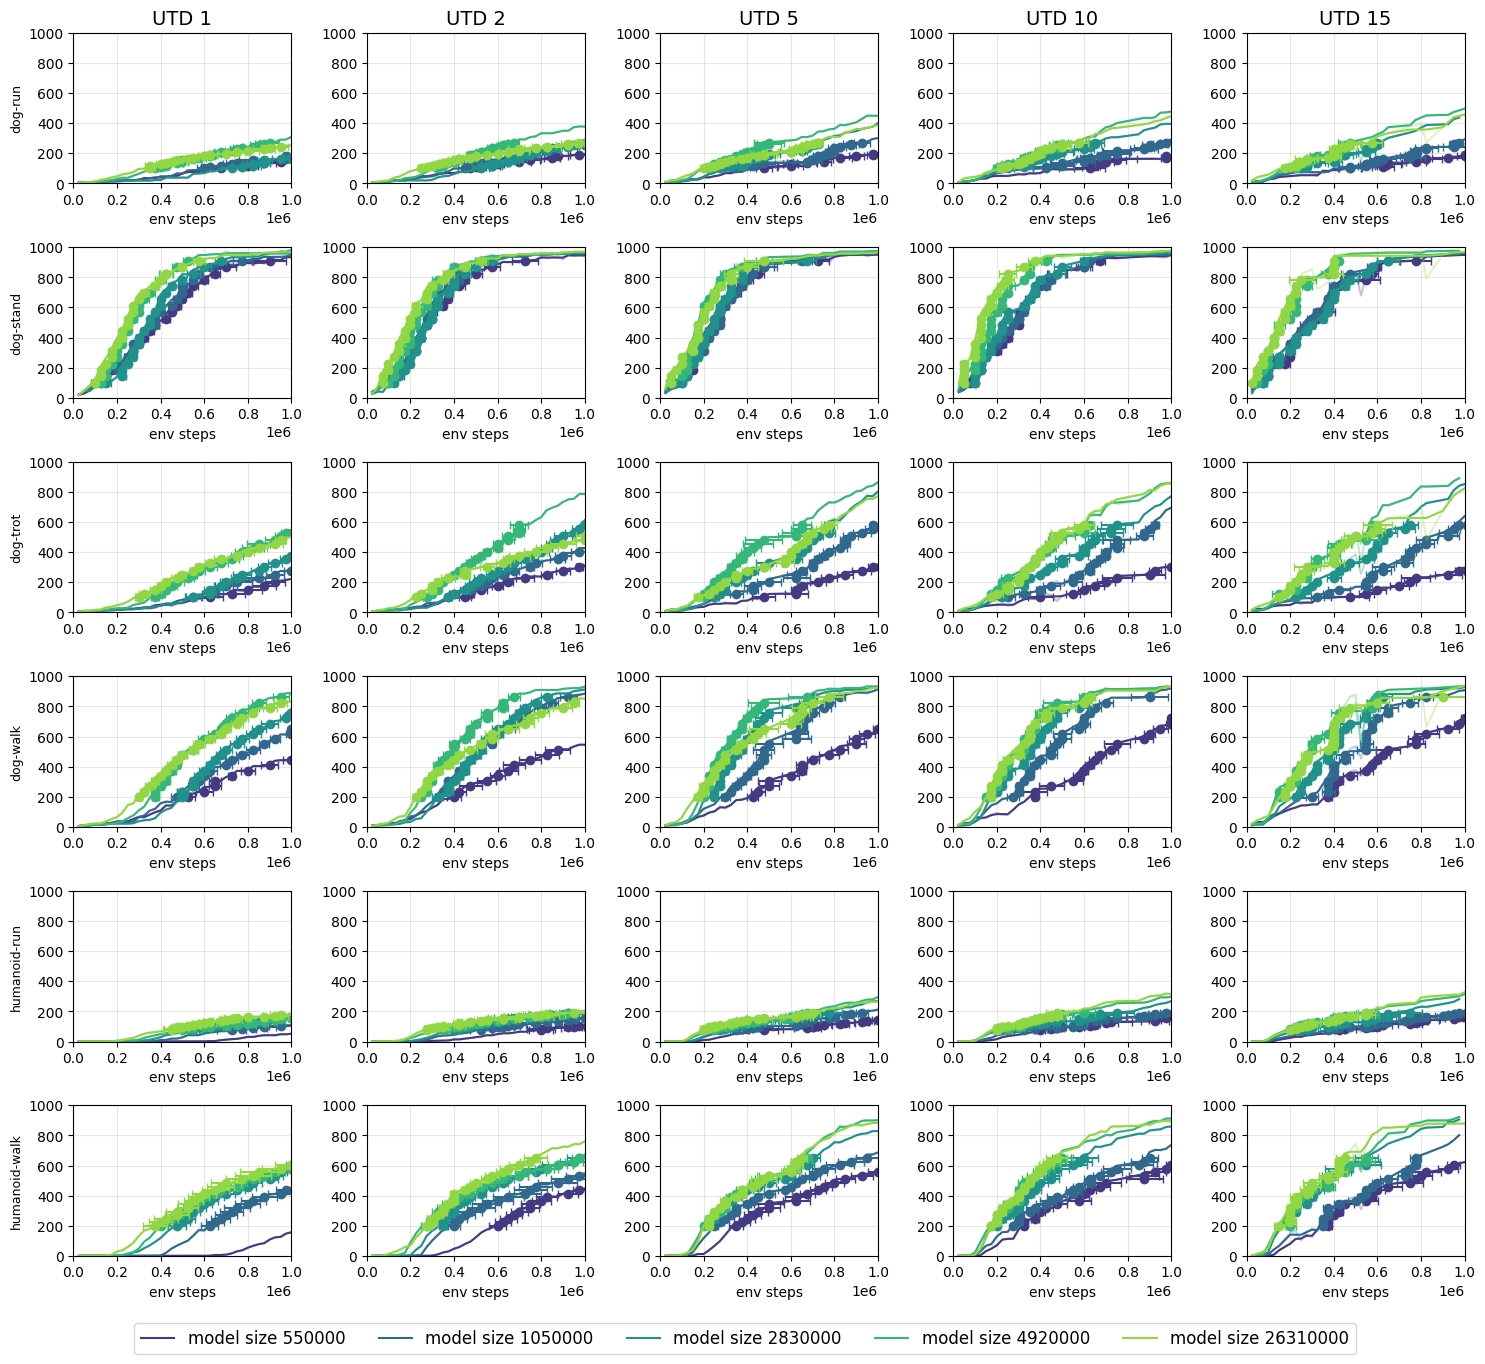

In [12]:
learning_curves_per_utd(df, ylabel_fontsize=9)

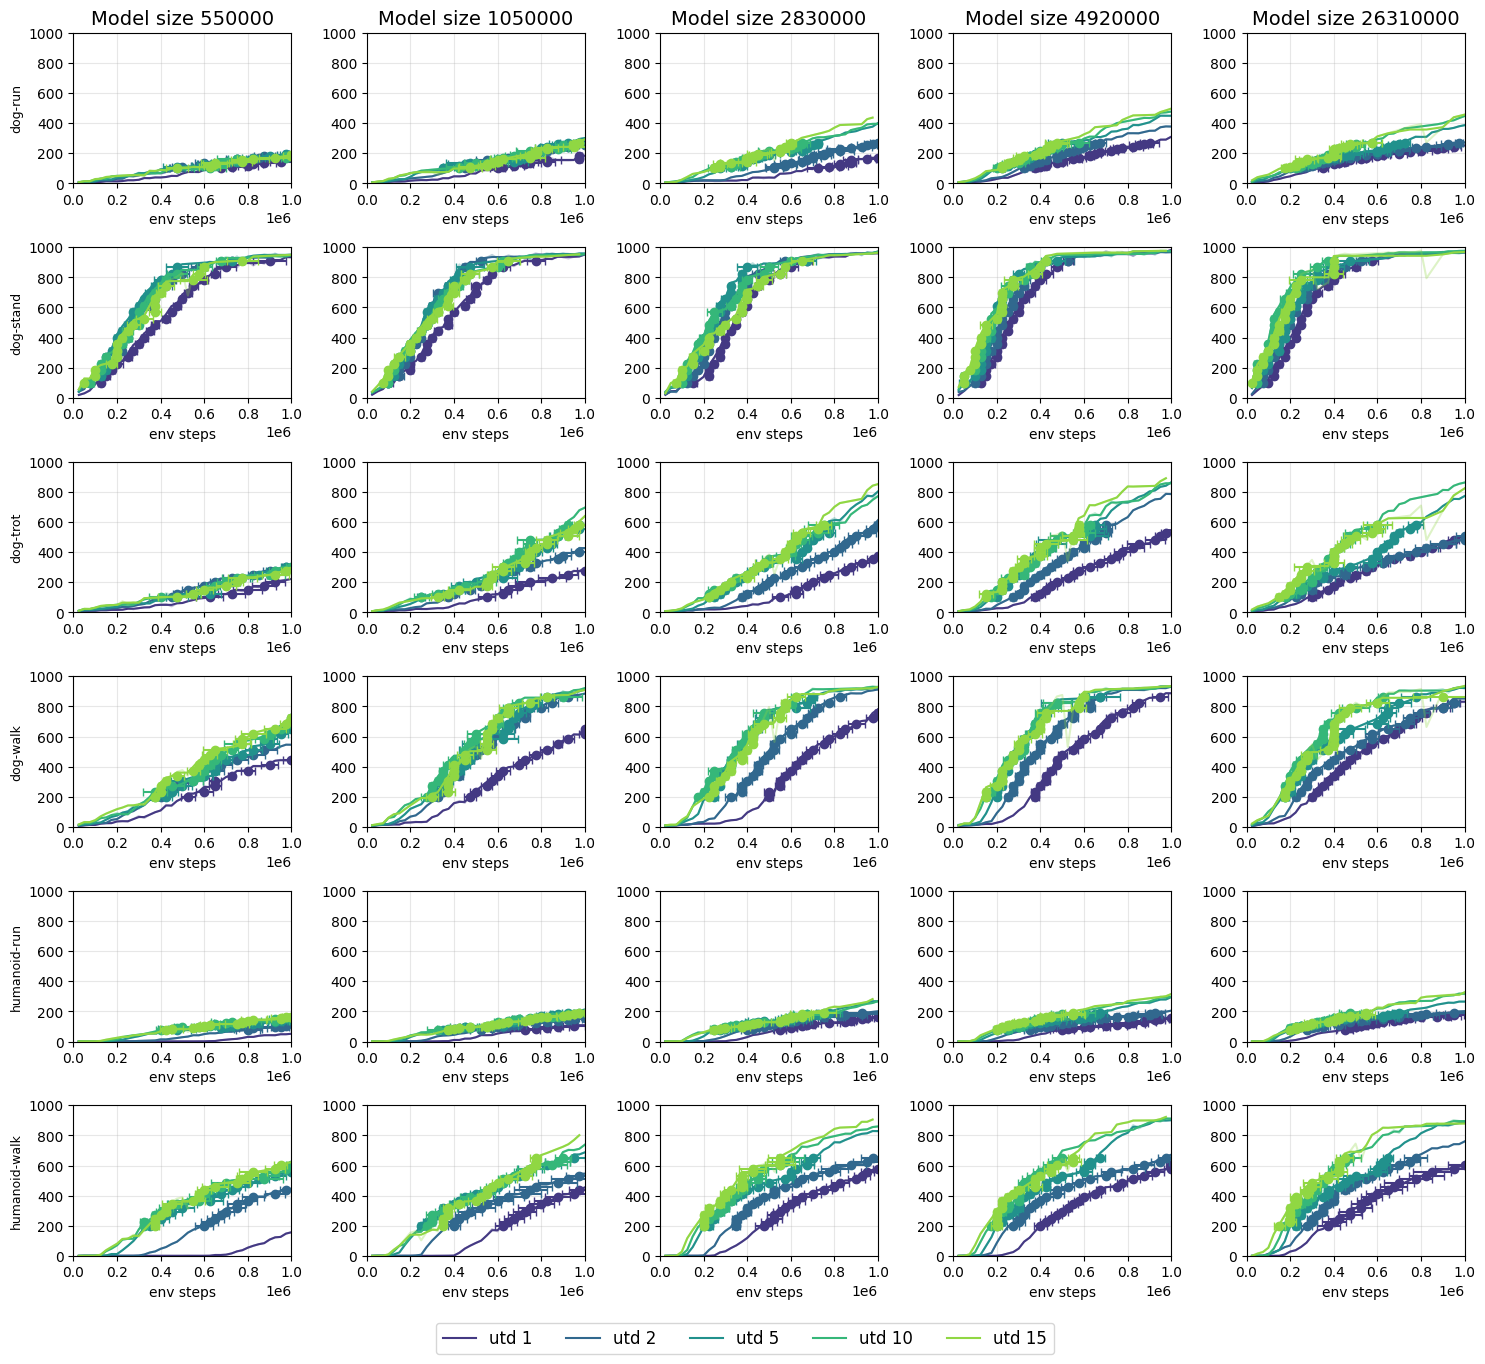

In [13]:
learning_curves_per_model_size(df, ylabel_fontsize=9)

# Data efficiency

In [14]:
env_data_efficiency_dict = compute_data_efficiency_per_env(df)

env=dog-run, utd=1, model_size=550000 has at least one nanmax return 152.6976615765817
env=dog-run, utd=1, model_size=1050000 has at least one nanmax return 183.80199932088436
env=dog-run, utd=1, model_size=2830000 has at least one nanmax return 172.307738084652
env=dog-run, utd=1, model_size=26310000 has at least one nanmax return 251.49430519749944
env=dog-run, utd=2, model_size=550000 has at least one nanmax return 194.1557028365172
env=dog-run, utd=2, model_size=1050000 has at least one nanmax return 267.1864739272729
env=dog-run, utd=5, model_size=550000 has at least one nanmax return 199.99515228451486
env=dog-run, utd=10, model_size=550000 has at least one nanmax return 184.82972401926415
env=dog-run, utd=15, model_size=550000 has at least one nanmax return 196.34936459945726
env=dog-trot, utd=1, model_size=550000 has at least one nanmax return 222.75181741578427
env=dog-trot, utd=1, model_size=1050000 has at least one nanmax return 291.33148137394255
env=dog-trot, utd=1, model_

In [15]:
def query(df, good_envs):
    if good_envs is None:
        return df
    return df.query(f'env_name in {good_envs}')


filtered_df = df.query(threshold_filter)

# Data efficiency fit per task

In [16]:
df['critic_params'] = df['model_size']
df['last_crossing'] = df['crossings'].apply(lambda x: x[-1])
df['last_crossing_std'] = df['crossings_std'].apply(lambda x: x[-1])
fit_df = df.dropna(subset=['last_crossing'])
xcols = ['utd', 'critic_params']

In [17]:
(
    fit_df,
    (
        time_to_thresh_model,
        time_to_thresh_shared_slope,
        time_to_thresh_env_intercepts,
        time_to_thresh_r2,
    ),
) = insert_predictions_shared_slope(fit_df, xcols, 'last_crossing')

predict_data_efficiency_shared_slope_ = lambda df: predict_log_linear_shared_slope(
    df, xcols, time_to_thresh_shared_slope, time_to_thresh_env_intercepts
)

dog-run: log last_crossing ~ 1.5356e+01 + -0.1184 * log utd + -0.1079 * log critic_params
dog-stand: log last_crossing ~ 1.5056e+01 + -0.1184 * log utd + -0.1079 * log critic_params
dog-trot: log last_crossing ~ 1.5412e+01 + -0.1184 * log utd + -0.1079 * log critic_params
dog-walk: log last_crossing ~ 1.5371e+01 + -0.1184 * log utd + -0.1079 * log critic_params
humanoid-run: log last_crossing ~ 1.5412e+01 + -0.1184 * log utd + -0.1079 * log critic_params
humanoid-walk: log last_crossing ~ 1.5314e+01 + -0.1184 * log utd + -0.1079 * log critic_params


In [ ]:
fit_df, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
    fit_df,
    xcols,
    'last_crossing',
    name=anonymous_data_config.name,
    use_cached=global_use_cached and True,
    log_loss=True,
)

predict_data_efficiency_sum_powerlaw_ = lambda df: predict_sum_of_powerlaw(
    df, xcols, time_to_thresh_sum_powerlaw_params
)

data_efficiency_sum_powerlaw_asymptotes_utd = {
    (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
    for k, params in time_to_thresh_sum_powerlaw_params.items()
    for utd in df['utd'].unique()
}

data_efficiency_sum_powerlaw_asymptotes_n = {
    (k, n): params[4] * (1 + (params[2] / n) ** params[3])
    for k, params in time_to_thresh_sum_powerlaw_params.items()
    for n in df['critic_params'].unique()
}

pd.DataFrame(
    [
        {
            'env_name': k,
            'a': params[0],
            'alpha': params[1],
            'b': params[2],
            'beta': params[3],
            'c': params[4],
            'alpha_unscaled': params[5],
            'beta_unscaled': params[6],
            'a_unscaled': params[7],
            'b_unscaled': params[8],
            'c_unscaled': params[9],
        }
        for k, params in time_to_thresh_sum_powerlaw_params.items()
    ]
)

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base/utd_critic_params_last_crossing_sum_powerlaw.npy


env_name         a     alpha             b       beta              c  \
0        dog-run  3.702034  0.435255  1.100674e+06   2.219761  345646.835803   
1      dog-stand  0.483587  1.463331  5.724116e+05   0.445174  355093.105270   
2       dog-trot  1.409581  0.339298  9.415943e+05   1.254338  402939.312536   
3       dog-walk  0.593185  1.633244  9.560687e+05  14.221015  663232.794880   
4   humanoid-run  1.619621  1.195731  9.133124e+05   0.994179  480326.427643   
5  humanoid-walk  6.744065  0.614177  1.409007e+06   1.077792  269176.048054   

   alpha_unscaled  beta_unscaled  a_unscaled  b_unscaled  c_unscaled  
0        0.850247       5.157782    0.977156    0.510246    0.467683  
1        2.858538       1.242044    0.344705    0.507209    0.594796  
2        0.493152       2.914548    0.393036    0.477092    0.528445  
3        3.190453      33.043595    0.382703    0.480235    0.880641  
4        1.737930       2.310048    0.432450    0.470872    0.626513  
5        0.892673       2.504332    1.153906    0.567464    0.384537

In [ ]:
fit_df, time_to_thresh_sum_powerlaw_shared_exponent_params = (
    insert_predictions_sum_of_powerlaw_shared_exponent(
        fit_df,
        xcols,
        'last_crossing',
        name=anonymous_data_config.name,
        use_cached=global_use_cached,
        log_loss=True,
    )
)

predict_data_efficiency_sum_powerlaw_shared_exponent_ = (
    lambda df: predict_sum_of_powerlaw_shared_exponent(
        df, xcols, time_to_thresh_sum_powerlaw_shared_exponent_params
    )
)

data_efficiency_sum_powerlaw_shared_exponent_asymptotes_utd = {
    (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
    for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
    for utd in df['utd'].unique()
}

data_efficiency_sum_powerlaw_shared_exponent_asymptotes_n = {
    (k, n): params[4] * (1 + (params[2] / n) ** params[3])
    for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
    for n in df['critic_params'].unique()
}

data_efficiency_sum_powerlaw_shared_exp_params_df = pd.DataFrame(
    [
        {
            'env_name': k,
            'a': params[0],
            'alpha': params[1],
            'b': params[2],
            'beta': params[3],
            'c': params[4],
            'alpha_unscaled': params[5],
            'beta_unscaled': params[6],
            'a_unscaled': params[7],
            'b_unscaled': params[8],
            'c_unscaled': params[9],
        }
        for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
    ]
)

data_efficiency_sum_powerlaw_shared_exp_params_df

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base/utd_critic_params_last_crossing_sum_of_powerlaw_shared_exp.npy


env_name         a     alpha             b      beta              c  \
0        dog-run  1.232242  0.729986  9.255464e+05  1.286014  444715.041382   
1      dog-stand  0.194474  0.729986  3.935693e+05  1.286014  440431.115289   
2       dog-trot  0.642238  0.729986  7.528799e+05  1.286014  537789.286603   
3       dog-walk  0.309242  0.729986  3.783812e+05  1.286014  603077.874999   
4   humanoid-run  2.039960  0.729986  1.001967e+06  1.286014  428939.401915   
5  humanoid-walk  3.812489  0.729986  1.132622e+06  1.286014  330236.675265   

   alpha_unscaled  beta_unscaled  a_unscaled  b_unscaled  c_unscaled  
0        1.425987       2.988151    0.556415    0.473576    0.590493  
1        1.425987       2.988151    0.216235    0.327763    0.584805  
2        1.425987       2.988151    0.398590    0.433308    0.714077  
3        1.425987       2.988151    0.274186    0.322258    0.800767  
4        1.425987       2.988151    0.720228    0.490025    0.569546  
5        1.425987       2.988151    0.991973    0.516568    0.438489

In [20]:
def print_data_efficiency_params(params_df):
    for _, row in params_df.iterrows():
        env_name, a, alpha, b, beta, c = row[['env_name', 'a', 'alpha', 'b', 'beta', 'c']].values
        print(
            r'\texttt{[[env]]}'.replace(r'[[env]]', env_name.replace('-v0', '')),
            r'&\qquad',
            r'\mathrm{[[c]]} \left(1 + \parens{\tfrac{\mathrm{[[a]]}}{\sigma}}^{[[\alpha]]} + \parens{\tfrac{\mathrm{[[b]]}}{N}}^{[[\beta]]} \right)'.replace(
                r'[[a]]', f'{a:.2e}'
            )
            .replace(r'[[b]]', f'{b:.2e}')
            .replace(r'[[c]]', f'{c:.2e}')
            .replace(r'[[\alpha]]', f'{alpha:.2f}')
            .replace(r'[[\beta]]', f'{beta:.2f}')
            .replace('e+0', r'e')
            .replace('e-0', r'e\text{-}'),
            r'\\',
        )


print_data_efficiency_params(data_efficiency_sum_powerlaw_shared_exp_params_df)

\texttt{dog-run} &\qquad \mathrm{4.45e5} \left(1 + \parens{\tfrac{\mathrm{1.23e0}}{\sigma}}^{0.73} + \parens{\tfrac{\mathrm{9.26e5}}{N}}^{1.29} \right) \\
\texttt{dog-stand} &\qquad \mathrm{4.40e5} \left(1 + \parens{\tfrac{\mathrm{1.94e\text{-}1}}{\sigma}}^{0.73} + \parens{\tfrac{\mathrm{3.94e5}}{N}}^{1.29} \right) \\
\texttt{dog-trot} &\qquad \mathrm{5.38e5} \left(1 + \parens{\tfrac{\mathrm{6.42e\text{-}1}}{\sigma}}^{0.73} + \parens{\tfrac{\mathrm{7.53e5}}{N}}^{1.29} \right) \\
\texttt{dog-walk} &\qquad \mathrm{6.03e5} \left(1 + \parens{\tfrac{\mathrm{3.09e\text{-}1}}{\sigma}}^{0.73} + \parens{\tfrac{\mathrm{3.78e5}}{N}}^{1.29} \right) \\
\texttt{humanoid-run} &\qquad \mathrm{4.29e5} \left(1 + \parens{\tfrac{\mathrm{2.04e0}}{\sigma}}^{0.73} + \parens{\tfrac{\mathrm{1.00e6}}{N}}^{1.29} \right) \\
\texttt{humanoid-walk} &\qquad \mathrm{3.30e5} \left(1 + \parens{\tfrac{\mathrm{3.81e0}}{\sigma}}^{0.73} + \parens{\tfrac{\mathrm{1.13e6}}{N}}^{1.29} \right) \\


In [21]:
compute_optimal_df['last_crossing'] = compute_optimal_df['crossings'].apply(lambda x: x[-1])
compute_optimal_df['last_crossing_std'] = (
    compute_optimal_df['crossings_bootstrap']
    .apply(lambda x: x[-1])
    .apply(lambda x: np.nanstd(x[x < np.inf]))
)

## Fitting multiple $J$

In [22]:
def make_multiple_crossings_df(df, interpolated_bs_df=None, extrapolated_bs_df=None):
    df = deepcopy(df)
    multiple_crossings_df = df[
        ['env_name', 'critic_params', 'utd', 'crossings', 'crossings_bootstrap']
    ]

    multiple_crossings_df = multiple_crossings_df.sort_values(
        ['env_name', 'utd', 'critic_params']
    ).reset_index(drop=True)

    for i in range(n_thresholds):
        multiple_crossings_df[f'crossing{i}'] = multiple_crossings_df['crossings'].apply(
            lambda x: x[i]
        )
        multiple_crossings_df[f'crossing{i}_std'] = multiple_crossings_df[
            'crossings_bootstrap'
        ].apply(lambda x: np.nanstd(x, axis=0)[i])
    multiple_crossings_df['time_to_threshold'] = multiple_crossings_df[
        f'crossing{n_thresholds - 1}'
    ]
    return multiple_crossings_df


generic_fit_infos = {
    'loglinear_shared': {
        'color': 'tab:orange',
        'label': r'$D \sim a_{\text{env},\sigma} \cdot N^{\beta}$',
    },
    'sum_powerlaw': {
        'color': 'tab:purple',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha_{\text{env}}}} + \dfrac{b_{\text{env}}}{N^{\beta_{\text{env}}}}$',
    },
    'sum_of_powerlaw_shared_exp': {
        'color': 'darkturquoise',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha}} + \dfrac{b_{\text{env}}}{N^{\beta}}$',
    },
    'sum_of_powerlaw_groupwise': {
        'color': 'crimson',
        'label': r'$\ell_2$ loss, $D_J \sim D_{\text{env}, J}^{\text{min}} + \dfrac{a_{\text{env}, J}}{\sigma^{\alpha_{\text{env}, J_g}}} + \dfrac{b_{\text{env}, J}}{N^{\beta_{\text{env}, J_g}}}$',
    },
    'sum_of_powerlaw_groupwise_p1': {
        'color': 'palevioletred',
        'label': r'$\ell_1$ loss, $D_J \sim D_{\text{env}, J}^{\text{min}} + \dfrac{a_{\text{env}, J}}{\sigma^{\alpha_{\text{env}, J_g}}} + \dfrac{b_{\text{env}, J}}{N^{\beta_{\text{env}, J_g}}}$',
    },
    'sum_of_powerlaw_groupwise_p4': {
        'color': 'darkmagenta',
        'label': r'$\ell_4$ loss, $D_J \sim D_{\text{env}, J}^{\text{min}} + \dfrac{a_{\text{env}, J}}{\sigma^{\alpha_{\text{env}, J_g}}} + \dfrac{b_{\text{env}, J}}{N^{\beta_{\text{env}, J_g}}}$',
    },
}

multiple_crossings_df = make_multiple_crossings_df(df)
time_to_thresholds_predictors = [{} for _ in range(n_thresholds)]
time_to_thresholds_infos_utd = [deepcopy(generic_fit_infos) for _ in range(n_thresholds)]
time_to_thresholds_infos_n = [deepcopy(generic_fit_infos) for _ in range(n_thresholds)]

multiple_crossings_state = (
    multiple_crossings_df,
    time_to_thresholds_predictors,
    time_to_thresholds_infos_utd,
    time_to_thresholds_infos_n,
)

/home/anonymous/miniconda3/envs/scale_rl2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anonymous/miniconda3/envs/scale_rl2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anonymous/miniconda3/envs/scale_rl2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anonymous/miniconda3/envs/scale_rl2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anonymous/miniconda3/envs/scale_rl2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedo

In [23]:
def insert_multiple_shared_slope(state, fn=insert_predictions_shared_slope):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'loglinear_shared'

    for i in range(n_thresholds):
        (
            multiple_crossings_df,
            (
                time_to_thresh_model,
                time_to_thresh_shared_slope,
                time_to_thresh_env_intercepts,
                time_to_thresh_r2,
            ),
        ) = fn(multiple_crossings_df, xcols, f'crossing{i}')

        predictor = (
            lambda params: (lambda df: predict_log_linear_shared_slope(df, xcols, *params))
        )((time_to_thresh_shared_slope, time_to_thresh_env_intercepts))
        predictors[i][fit_type] = predictor

        params = {'slope': time_to_thresh_shared_slope, 'intercept': time_to_thresh_env_intercepts}
        infos_utd[i][fit_type]['params'] = params
        infos_n[i][fit_type]['params'] = params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


multiple_crossings_state = insert_multiple_shared_slope(multiple_crossings_state)

dog-run: log crossing0 ~ 1.5916e+01 + -0.2521 * log utd + -0.1863 * log critic_params
dog-stand: log crossing0 ~ 1.4408e+01 + -0.2521 * log utd + -0.1863 * log critic_params
dog-trot: log crossing0 ~ 1.5730e+01 + -0.2521 * log utd + -0.1863 * log critic_params
dog-walk: log crossing0 ~ 1.5675e+01 + -0.2521 * log utd + -0.1863 * log critic_params
humanoid-run: log crossing0 ~ 1.5915e+01 + -0.2521 * log utd + -0.1863 * log critic_params
humanoid-walk: log crossing0 ~ 1.5742e+01 + -0.2521 * log utd + -0.1863 * log critic_params
dog-run: log crossing1 ~ 1.6134e+01 + -0.2424 * log utd + -0.1975 * log critic_params
dog-stand: log crossing1 ~ 1.4824e+01 + -0.2424 * log utd + -0.1975 * log critic_params
dog-trot: log crossing1 ~ 1.6007e+01 + -0.2424 * log utd + -0.1975 * log critic_params
dog-walk: log crossing1 ~ 1.5898e+01 + -0.2424 * log utd + -0.1975 * log critic_params
humanoid-run: log crossing1 ~ 1.6118e+01 + -0.2424 * log utd + -0.1975 * log critic_params
humanoid-walk: log crossing1 ~

In [ ]:
def insert_multiple_sum_powerlaw(state, config, use_cached):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'sum_powerlaw'
    kw = dict(use_cached=global_use_cached and use_cached, log_loss=True)

    for i in tqdm(range(n_thresholds)):
        multiple_crossings_df, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
            multiple_crossings_df, xcols, f'crossing{i}', name=f'{config.name}_crossing{i}', **kw
        )

        predict_data_efficiency_sum_powerlaw_ = (
            lambda params: (lambda df: predict_sum_of_powerlaw(df, xcols, params))
        )(time_to_thresh_sum_powerlaw_params)

        data_efficiency_sum_powerlaw_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for utd in set(df['utd'].unique())  # | set(extrapolated_bs_df['utd'].unique())
        }

        data_efficiency_sum_powerlaw_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for n in set(df['critic_params'].unique())
        }

        predictors[i][fit_type] = predict_data_efficiency_sum_powerlaw_
        infos_utd[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_utd
        infos_n[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_n
        infos_utd[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params
        infos_n[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


multiple_crossings_state = insert_multiple_sum_powerlaw(
    multiple_crossings_state, anonymous_data_config, use_cached=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing0/utd_critic_params_crossing0_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing1/utd_critic_params_crossing1_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing2/utd_critic_params_crossing2_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing3/utd_critic_params_crossing3_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing4/utd_critic_params_crossing4_sum_powerlaw.npy
Loaded par

100%|██████████| 20/20 [00:00<00:00, 112.17it/s]

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing11/utd_critic_params_crossing11_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing12/utd_critic_params_crossing12_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing13/utd_critic_params_crossing13_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing14/utd_critic_params_crossing14_sum_powerlaw.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing15/utd_critic_params_crossing15_sum_powerlaw.npy


In [ ]:
def insert_multiple_sum_powerlaw_shared_exp(state, config, use_cached):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'sum_of_powerlaw_shared_exp'
    kw = dict(use_cached=global_use_cached and use_cached, log_loss=False)

    for i in tqdm(range(n_thresholds)):
        multiple_crossings_df, time_to_thresh_sum_powerlaw_shared_exponent_params = (
            insert_predictions_sum_of_powerlaw_shared_exponent(
                multiple_crossings_df,
                xcols,
                f'crossing{i}',
                name=f'{config.name}_crossing{i}',
                **kw,
            )
        )

        predict_data_efficiency_sum_powerlaw_shared_exponent_ = (
            lambda params: (lambda df: predict_sum_of_powerlaw_shared_exponent(df, xcols, params))
        )(time_to_thresh_sum_powerlaw_shared_exponent_params)

        data_efficiency_sum_powerlaw_shared_exponent_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
            for utd in set(df['utd'].unique())  # | set(extrapolated_bs_df['utd'].unique())
        }

        data_efficiency_sum_powerlaw_shared_exponent_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
            for n in set(
                df['critic_params'].unique()
            )  # | set(extrapolated_bs_df['critic_params'].unique())
        }

        predictors[i][fit_type] = predict_data_efficiency_sum_powerlaw_shared_exponent_
        infos_utd[i][fit_type]['asymptote'] = (
            data_efficiency_sum_powerlaw_shared_exponent_asymptotes_utd
        )
        infos_n[i][fit_type]['asymptote'] = (
            data_efficiency_sum_powerlaw_shared_exponent_asymptotes_n
        )
        infos_utd[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_shared_exponent_params
        infos_n[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_shared_exponent_params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


multiple_crossings_state = insert_multiple_sum_powerlaw_shared_exp(
    multiple_crossings_state, anonymous_data_config, use_cached=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing0/utd_critic_params_crossing0_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing1/utd_critic_params_crossing1_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing2/utd_critic_params_crossing2_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing3/utd_critic_params_crossing3_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymo

 60%|██████    | 12/20 [00:00<00:00, 114.24it/s]/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[idx, f'{ycol}_sum_of_powerlaw_shared_exp'] = predict_sum_of_powerlaw_shared_exponent(
/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[idx, f'{ycol}_sum_of_powerlaw_shared_exp'] = predict_sum_of_powerlaw_shared_exponent(
/home/anonymous/model_scaling_project/single/scr

Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing10/utd_critic_params_crossing10_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing11/utd_critic_params_crossing11_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing12/utd_critic_params_crossing12_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_crossing13/utd_critic_params_crossing13_sum_of_powerlaw_shared_exp_no_log_loss.npy
Loaded params from /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits

In [26]:
(
    multiple_crossings_df,
    time_to_thresholds_predictors,
    time_to_thresholds_infos_utd,
    time_to_thresholds_infos_n,
) = multiple_crossings_state

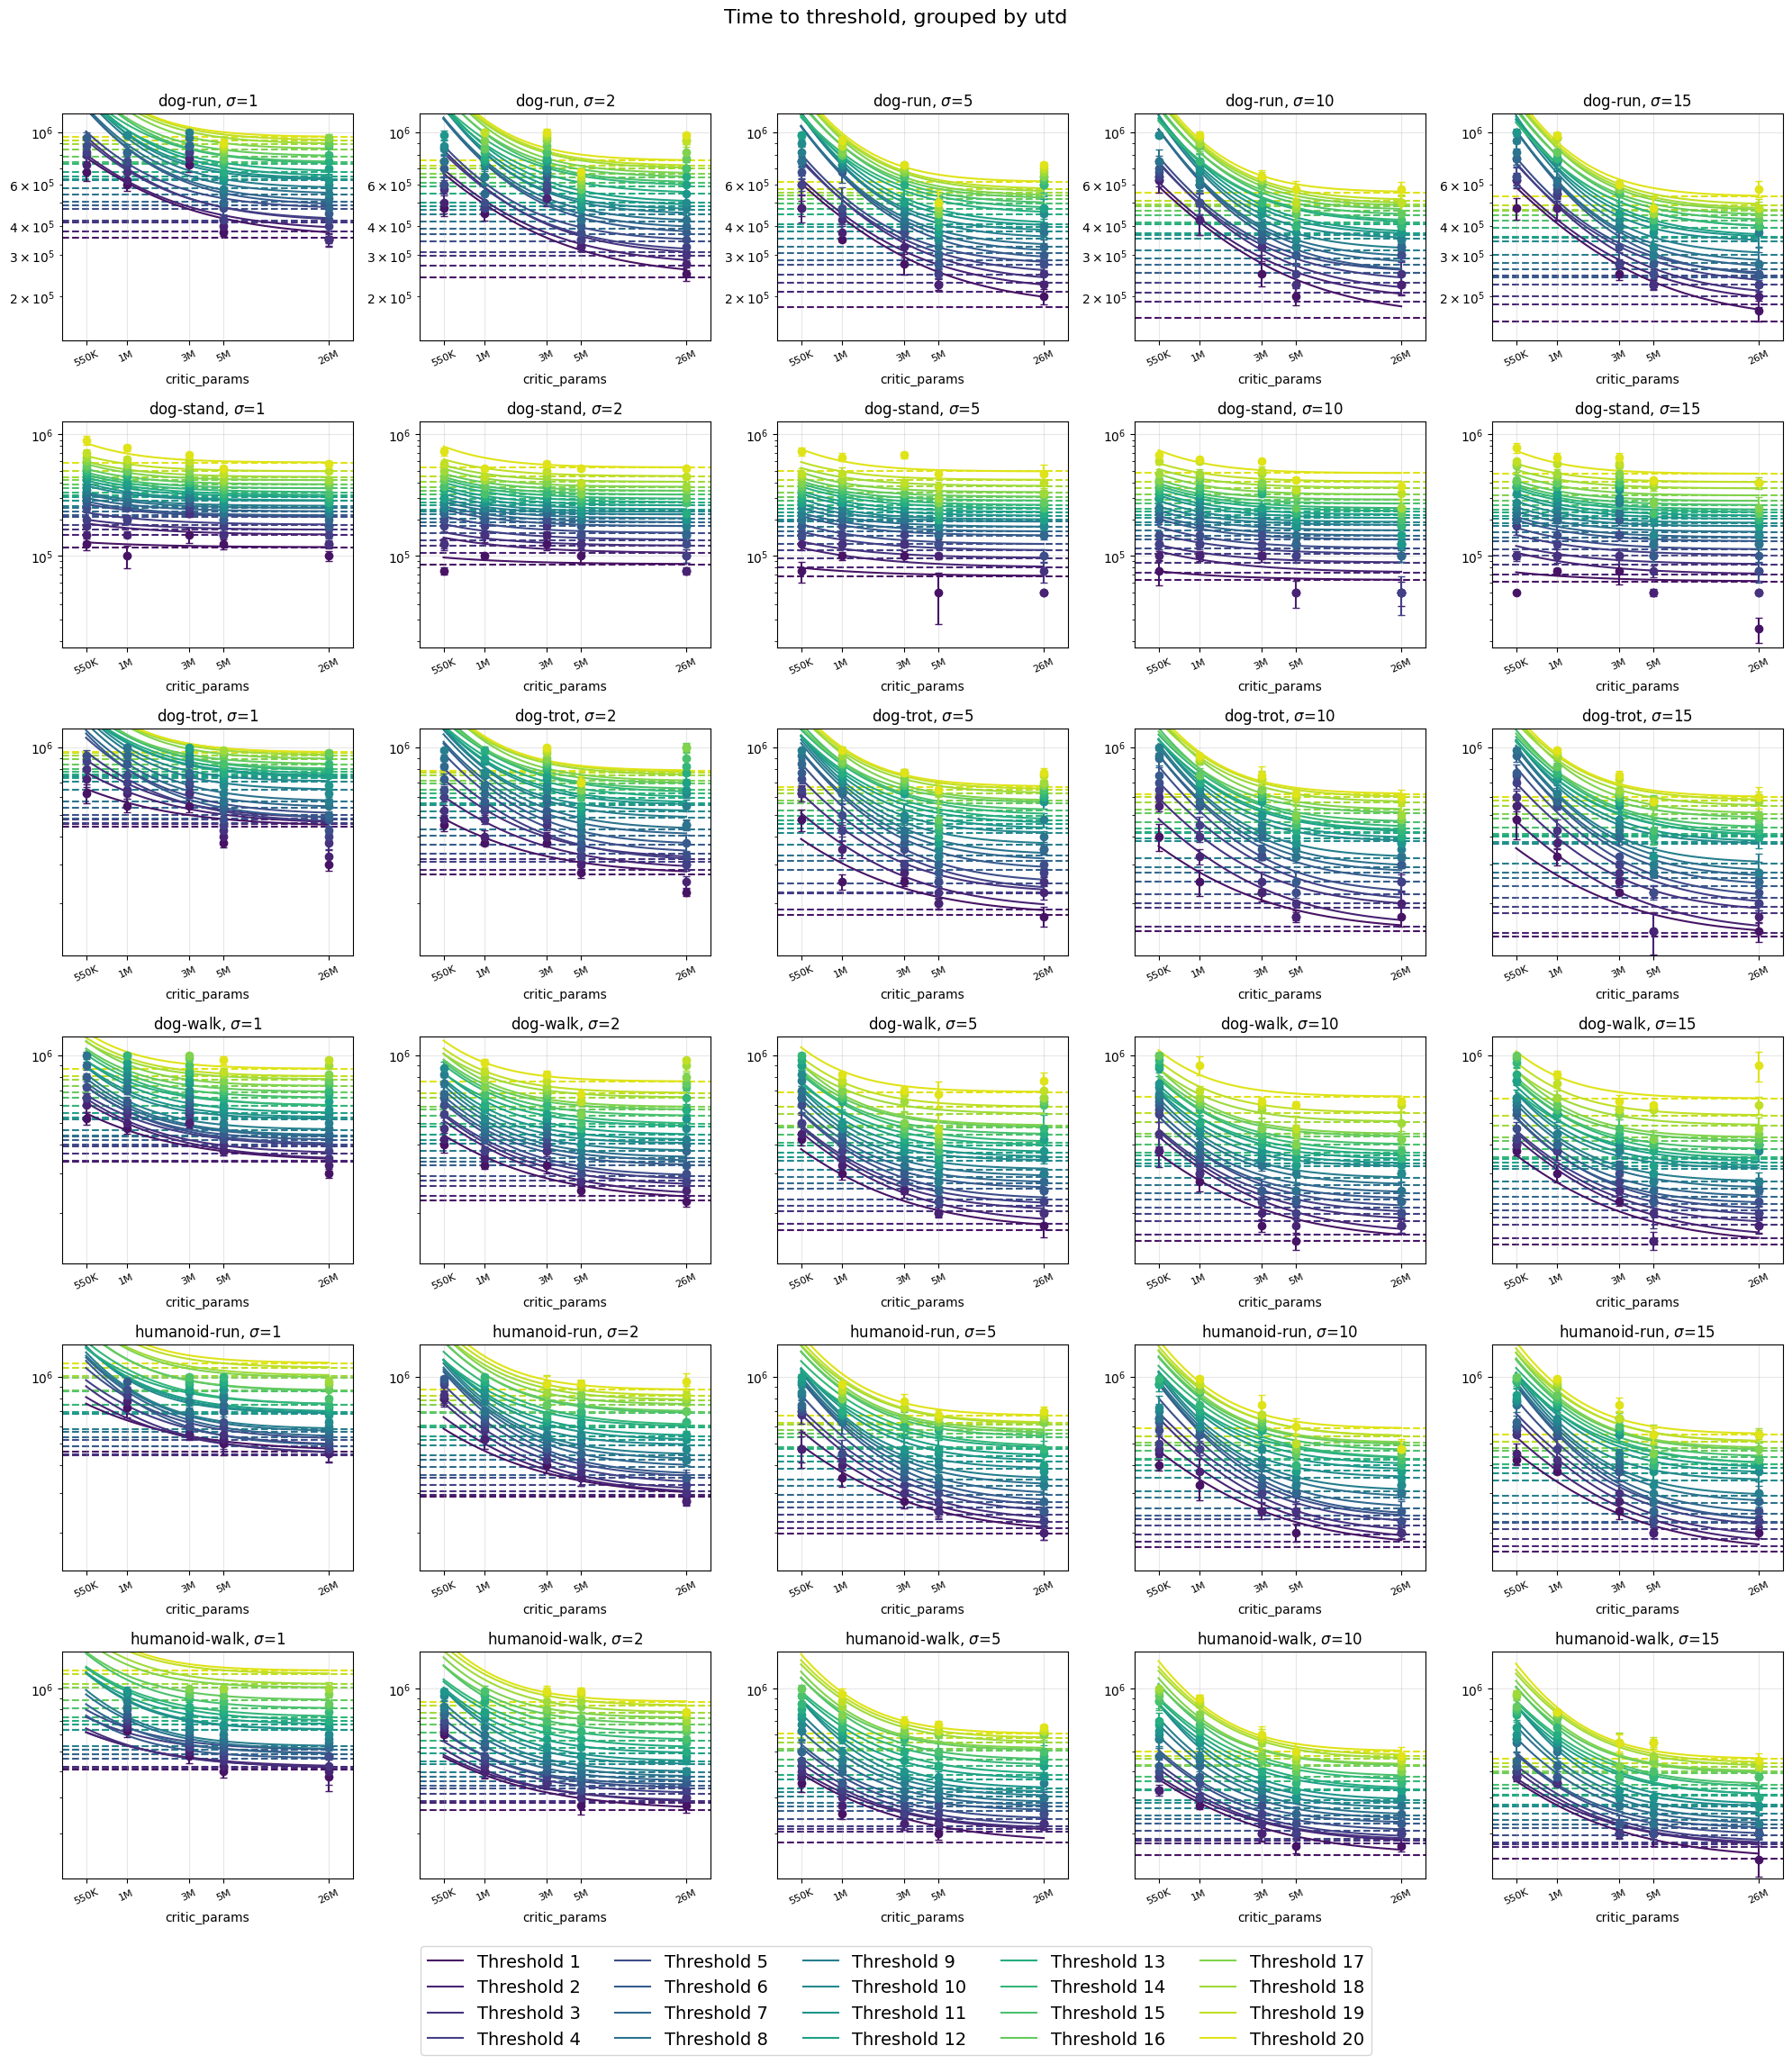

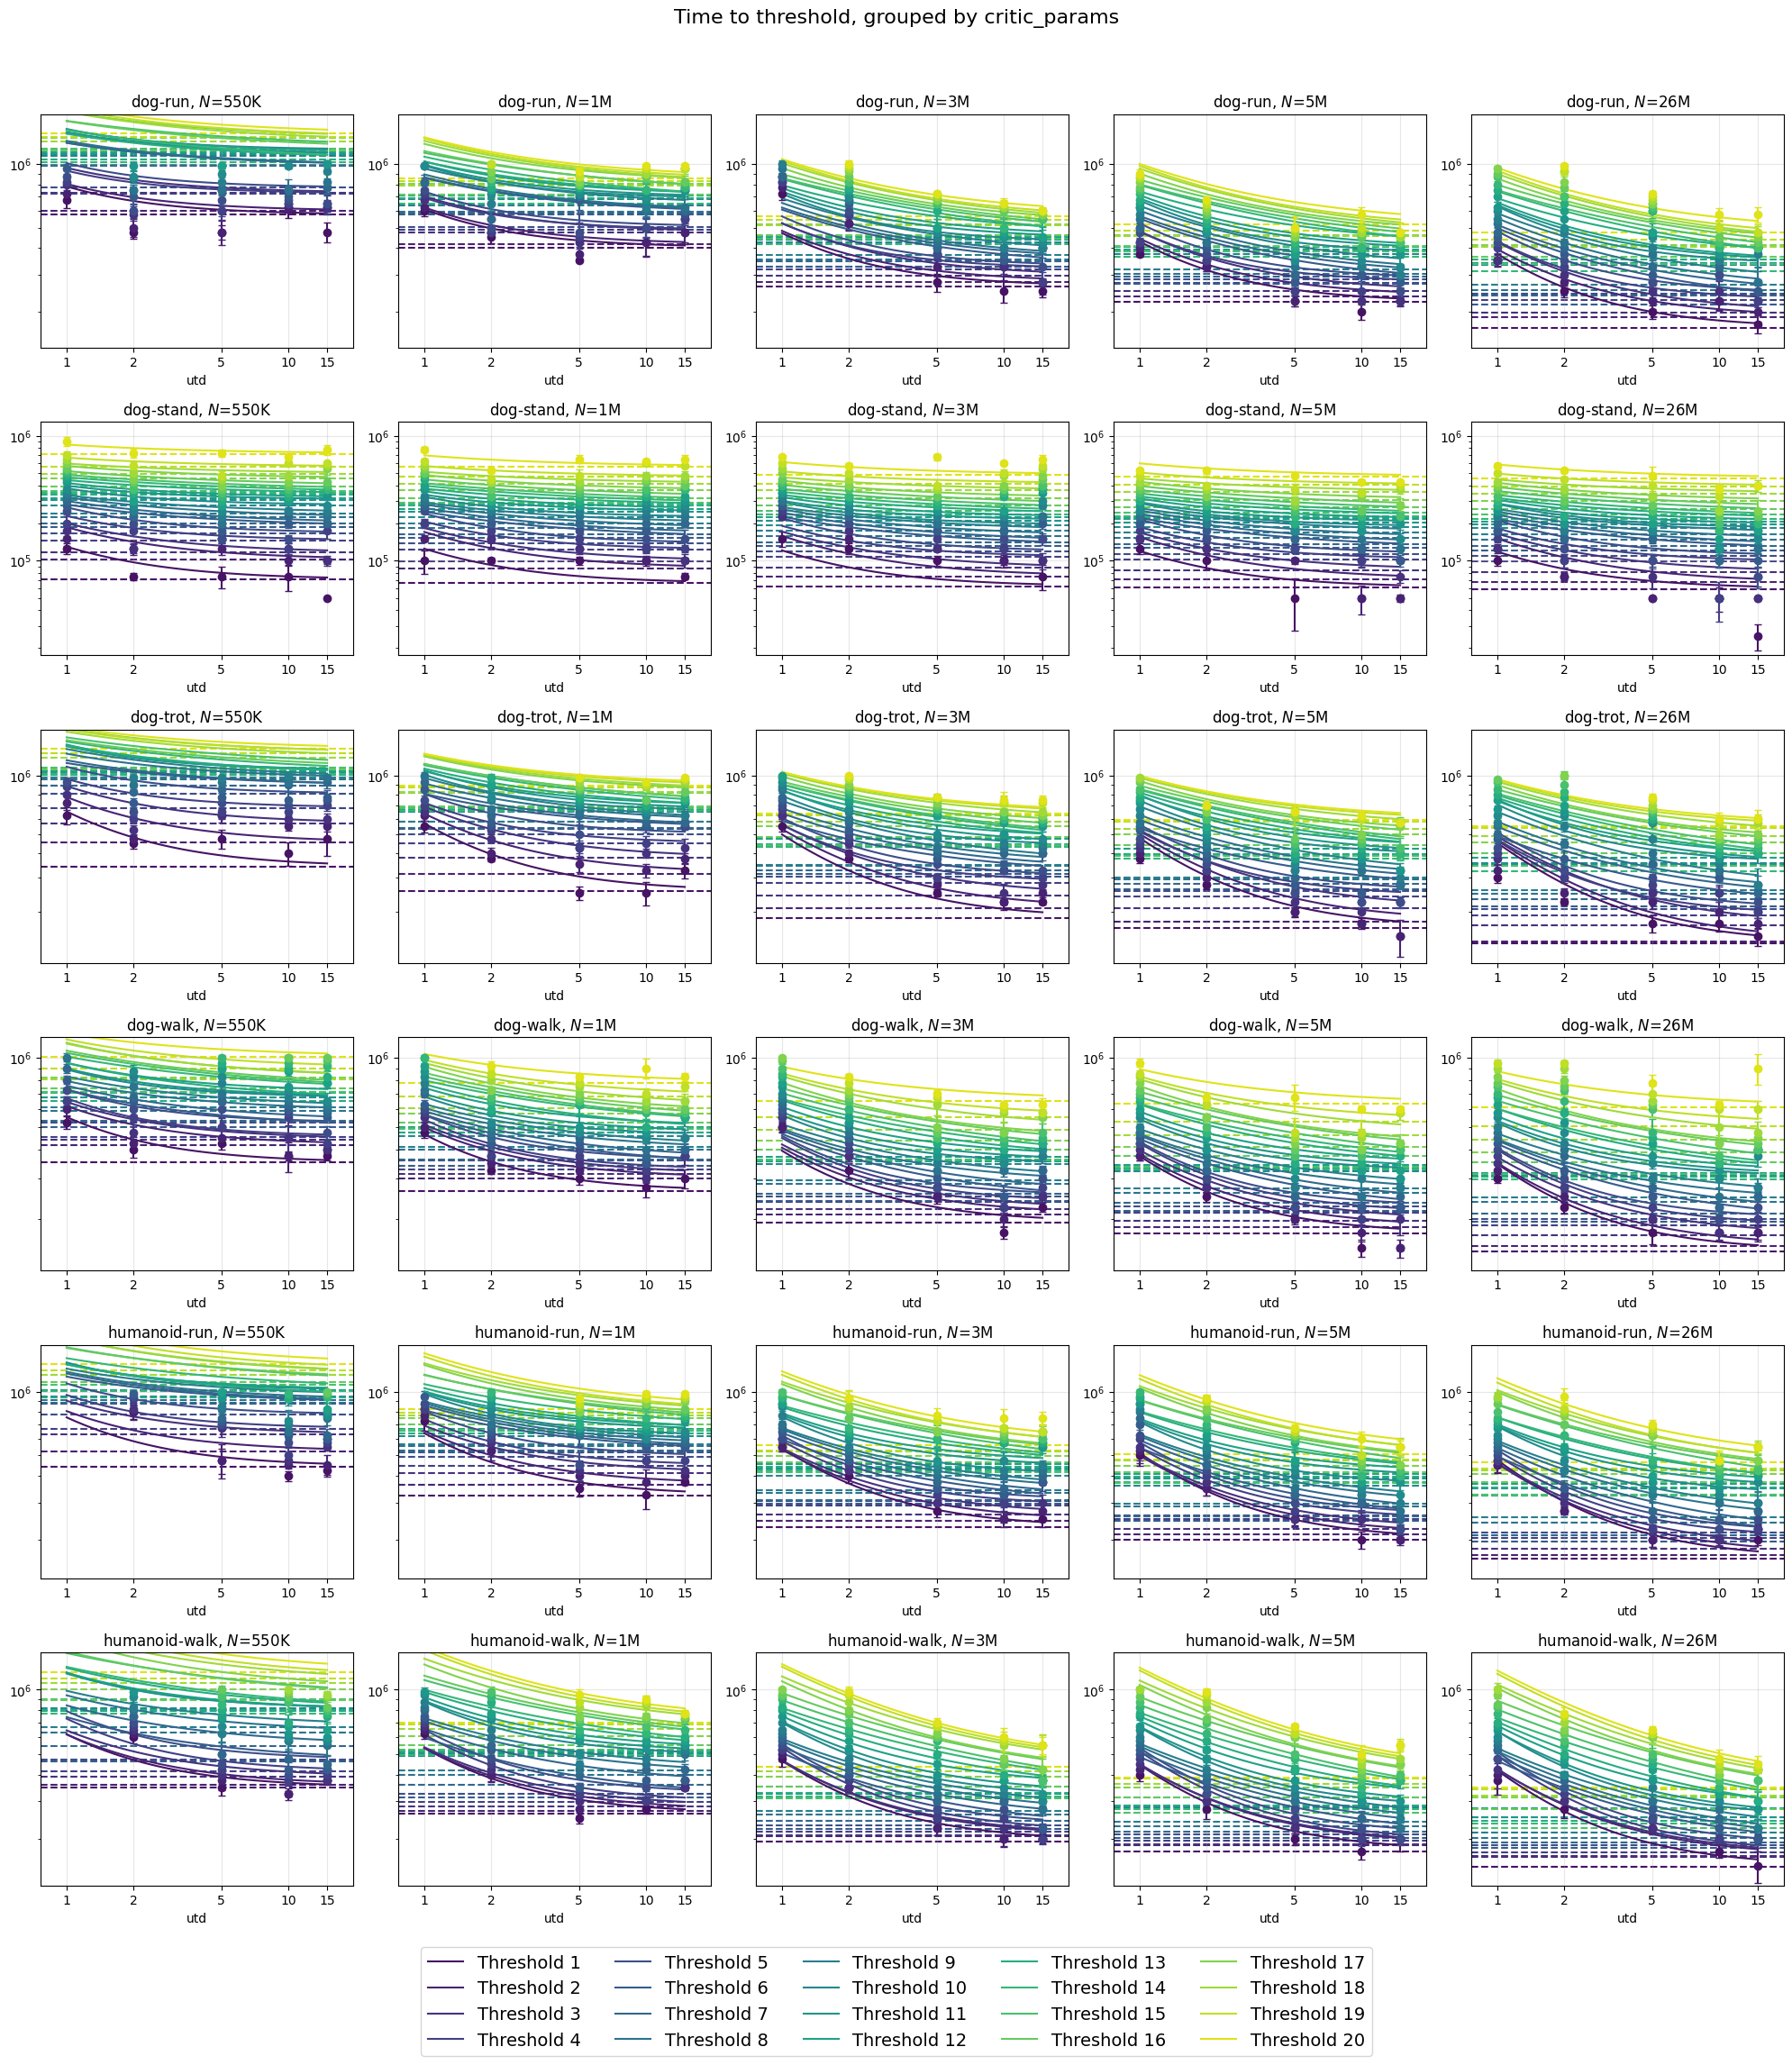

In [27]:
def plot_multiple_data_efficiency(multiple_crossings_state, fit_type):
    (
        multiple_crossings_df,
        time_to_thresholds_predictors,
        time_to_thresholds_infos_utd,
        time_to_thresholds_infos_n,
    ) = multiple_crossings_state

    dfs_list = []
    for i in range(n_thresholds):
        cols = ['env_name', 'critic_params', 'utd', f'crossing{i}', f'crossing{i}_std']
        dfs_list.append(
            multiple_crossings_df[cols].rename(
                columns={f'crossing{i}': 'time', f'crossing{i}_std': 'time_std'}
            )
        )

    plot_optimal_hparam_fit_per_env_utd_multiple_thresh(
        dfs_list,
        'time',
        'time_std',
        'Time to threshold',
        [
            (time_to_thresholds_predictors[i][fit_type], time_to_thresholds_infos_utd[i][fit_type])
            for i in range(n_thresholds)
        ],
    )

    plot_optimal_hparam_fit_per_env_n_multiple_thresh(
        dfs_list,
        'time',
        'time_std',
        'Time to threshold',
        [
            (time_to_thresholds_predictors[i][fit_type], time_to_thresholds_infos_n[i][fit_type])
            for i in range(n_thresholds)
        ],
        group_col='critic_params',
    )


plot_multiple_data_efficiency(multiple_crossings_state, 'sum_of_powerlaw_shared_exp')

# Averaged

## Fitting

In [28]:
normalized_times_all, mean_normalized_times, median_median = compute_normalized_times(
    env_data_efficiency_dict, query(filtered_df, good_envs), n_thresholds
)
std_normalized_times = np.std(normalized_times_all, axis=0)

In [ ]:
def make_averaged_threshold_dfs(df, mean_normalized_times, median_median):
    utds = sorted(df['utd'].unique())
    model_sizes = sorted(df['model_size'].unique())
    threshold_dfs = []

    for threshold_idx in range(mean_normalized_times.shape[2]):
        datas = []
        for i, utd in enumerate(utds):
            for j, model_size in enumerate(model_sizes):
                time = median_median * mean_normalized_times[i, j, threshold_idx]
                time_std = median_median * std_normalized_times[i, j, threshold_idx]
                datas.append([utd, model_size, time, time_std])
        threshold_df = pd.DataFrame(datas, columns=['utd', 'critic_params', 'time', 'time_std'])
        threshold_df['env_name'] = ''
        threshold_dfs.append(threshold_df)

    return threshold_dfs


def make_averaged_threshold_fits(threshold_dfs, use_cached=True):
    predict_fns = []
    params_sets = []
    asymptotes_per_utd = []
    asymptotes_per_model_size = []

    for threshold_idx, threshold_df in enumerate(threshold_dfs):
        # linear
        (
            threshold_df,
            (
                time_to_thresh_model,
                time_to_thresh_shared_slope,
                time_to_thresh_env_intercepts,
                time_to_thresh_r2,
            ),
        ) = insert_predictions(threshold_df, xcols, 'time')

        predict_data_efficiency_shared_slope_ = (
            lambda slope, intercept: lambda df: predict_log_linear(df, xcols, slope, intercept)
        )(time_to_thresh_shared_slope, time_to_thresh_env_intercepts)

        # sum powerlaw
        threshold_df, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
            threshold_df,
            xcols,
            'time',
            name=f'{anonymous_data_config.name}_averaged_threshold{threshold_idx}',
            use_cached=use_cached,
            log_loss=True,
        )

        predict_data_efficiency_sum_powerlaw_ = (
            lambda params: lambda df: predict_sum_of_powerlaw(df, xcols, params)
        )(time_to_thresh_sum_powerlaw_params)

        data_efficiency_sum_powerlaw_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for utd in df['utd'].unique()
        }

        data_efficiency_sum_powerlaw_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for n in df['critic_params'].unique()
        }

        threshold_dfs[threshold_idx] = threshold_df
        predict_fns.append(
            {
                'linear': predict_data_efficiency_shared_slope_,
                'sum_powerlaw': predict_data_efficiency_sum_powerlaw_,
            }
        )
        params_sets.append({'sum_powerlaw': time_to_thresh_sum_powerlaw_params})
        asymptotes_per_utd.append({'sum_powerlaw': data_efficiency_sum_powerlaw_asymptotes_utd})
        asymptotes_per_model_size.append(
            {'sum_powerlaw': data_efficiency_sum_powerlaw_asymptotes_n}
        )

    return threshold_dfs, predict_fns, params_sets, asymptotes_per_utd, asymptotes_per_model_size


averaged_threshold_dfs = make_averaged_threshold_dfs(
    query(filtered_df, good_envs), mean_normalized_times, median_median
)
(
    averaged_threshold_dfs,
    averaged_predict_fns,
    averaged_params_sets,
    averaged_asymptotes_per_utd,
    averaged_asymptotes_per_model_size,
) = make_averaged_threshold_fits(averaged_threshold_dfs, use_cached=global_use_cached and False)

: log time ~ 1.5338e+01 + -0.2020 * log utd + -0.1722 * log critic_params
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_threshold0/utd_critic_params_time_sum_powerlaw.npy
: log time ~ 1.5436e+01 + -0.1935 * log utd + -0.1737 * log critic_params
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_threshold1/utd_critic_params_time_sum_powerlaw.npy
: log time ~ 1.5509e+01 + -0.1807 * log utd + -0.1743 * log critic_params
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_threshold2/utd_critic_params_time_sum_powerlaw.npy
: log time ~ 1.5541e+01 + -0.1676 * log utd + -0.1734 * log critic_params
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_

In [30]:
averaged_data_efficiency_sum_powerlaw_params_df = pd.DataFrame(
    [
        {
            'threshold': i,
            'a': params_set['sum_powerlaw'][''][0],
            'alpha': params_set['sum_powerlaw'][''][1],
            'b': params_set['sum_powerlaw'][''][2],
            'beta': params_set['sum_powerlaw'][''][3],
            'c': params_set['sum_powerlaw'][''][4],
            'alpha_unscaled': params_set['sum_powerlaw'][''][5],
            'beta_unscaled': params_set['sum_powerlaw'][''][6],
            'a_unscaled': params_set['sum_powerlaw'][''][7],
            'b_unscaled': params_set['sum_powerlaw'][''][8],
            'c_unscaled': params_set['sum_powerlaw'][''][9],
        }
        for i, params_set in enumerate(averaged_params_sets)
    ]
)

averaged_data_efficiency_sum_powerlaw_params_df

threshold         a     alpha             b      beta              c  \
0           0  1.680201  1.626462  1.128110e+06  0.859077  137278.138704   
1           1  1.589596  1.449958  1.119920e+06  0.948674  151921.921399   
2           2  1.504111  1.357684  1.144741e+06  0.919226  164562.021539   
3           3  1.433406  1.421934  1.130814e+06  0.884530  178547.694790   
4           4  1.346569  1.377435  1.082885e+06  1.010202  198569.581572   
5           5  1.281866  1.021044  1.141811e+06  1.069882  205936.908217   
6           6  1.286725  1.249872  1.039504e+06  1.076941  230812.411325   
7           7  1.265492  0.953467  1.071009e+06  1.149235  236143.780810   
8           8  1.180637  1.028963  1.008760e+06  1.167383  261973.034790   
9           9  1.192105  1.494587  8.930272e+05  1.301424  311978.924723   
10         10  1.180761  1.539451  8.694770e+05  1.200031  330039.453744   
11         11  1.175304  1.518190  8.421512e+05  1.147428  348583.955505   
12         12  1.173483  1.136915  8.349647e+05  1.106147  349482.424630   
13         13  1.281142  0.900224  8.933598e+05  1.106794  341638.542860   
14         14  1.563561  0.667284  9.339202e+05  1.190257  329311.625687   
15         15  1.112658  0.835311  7.158568e+05  1.148008  398130.622780   
16         16  1.169899  0.825872  7.668886e+05  1.249832  413409.355154   
17         17  1.109440  1.423161  6.029146e+05  1.076311  503866.306907   
18         18  1.058732  1.342565  6.348565e+05  1.314317  543305.712933   
19         19  0.892123  0.772771  6.676976e+05  1.267181  539065.092706   

    alpha_unscaled  beta_unscaled  a_unscaled  b_unscaled  c_unscaled  
0         2.363974       1.996130    0.443515    0.515681    0.579962  
1         2.107434       2.204315    0.426918    0.514067    0.587321  
2         1.973320       2.135890    0.410986    0.518939    0.584570  
3         2.066704       2.055273    0.397595    0.516213    0.592567  
4         2.002026       2.347281    0.380862    0.506680    0.613267  
5         1.484031       2.485951    0.368174    0.518367    0.586906  
6         1.816620       2.502353    0.369134    0.497843    0.621280  
7         1.385812       2.670334    0.364932    0.504281    0.596341  
8         1.495542       2.712501    0.347915    0.491452    0.621694  
9         2.172301       3.023957    0.350236    0.466342    0.688588  
10        2.237507       2.788363    0.347940    0.461009    0.689132  
11        2.206606       2.666135    0.346833    0.454717    0.689350  
12        1.652444       2.570216    0.346463    0.453043    0.656889  
13        1.308426       2.571719    0.368031    0.466417    0.612443  
14        0.969861       2.765652    0.422095    0.475415    0.561269  
15        1.214079       2.667482    0.334005    0.424006    0.649110  
16        1.200359       2.904079    0.345735    0.436760    0.642214  
17        2.068486       2.500889    0.333340    0.393803    0.728640  
18        1.951345       3.053913    0.322781    0.402650    0.744798  
19        1.123180       2.944389    0.286911    0.411486    0.679318

In [31]:
def wrap(params_df):
    params_df = deepcopy(params_df.iloc[-1:])
    params_df['env_name'] = 'averaged'
    print_data_efficiency_params(params_df)


wrap(averaged_data_efficiency_sum_powerlaw_params_df)

\texttt{averaged} &\qquad \mathrm{5.39e5} \left(1 + \parens{\tfrac{\mathrm{8.92e\text{-}1}}{\sigma}}^{0.77} + \parens{\tfrac{\mathrm{6.68e5}}{N}}^{1.27} \right) \\


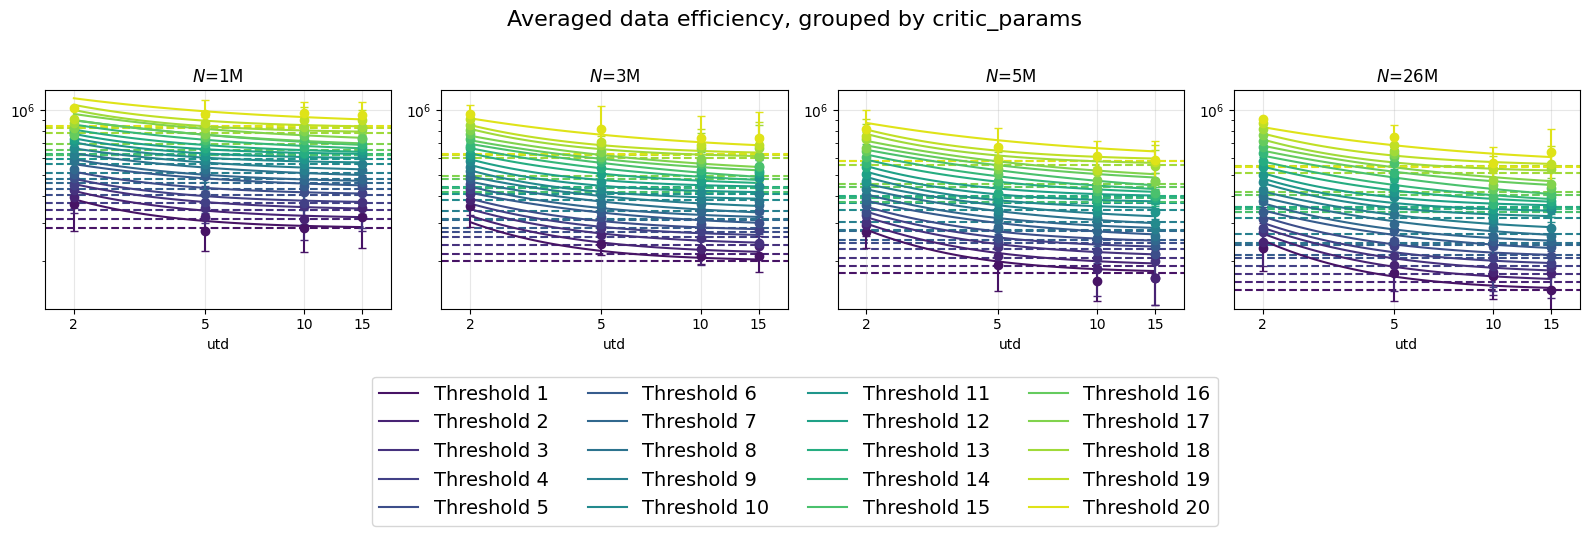

In [32]:
plot_optimal_hparam_fit_per_env_n_multiple_thresh(
    averaged_threshold_dfs,
    'time',
    'time_std',
    'Averaged data efficiency',
    [
        (
            predict_fns_['sum_powerlaw'],
            {
                'asymptote': asymptotes_per_model_size_['sum_powerlaw'],
                # 'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha_{\text{env}}}} + \dfrac{b_{\text{env}}}{N^{\beta_{\text{env}}}}$',
            },
        )
        for predict_fns_, asymptotes_per_model_size_ in zip(
            averaged_predict_fns, averaged_asymptotes_per_model_size
        )
    ],
)

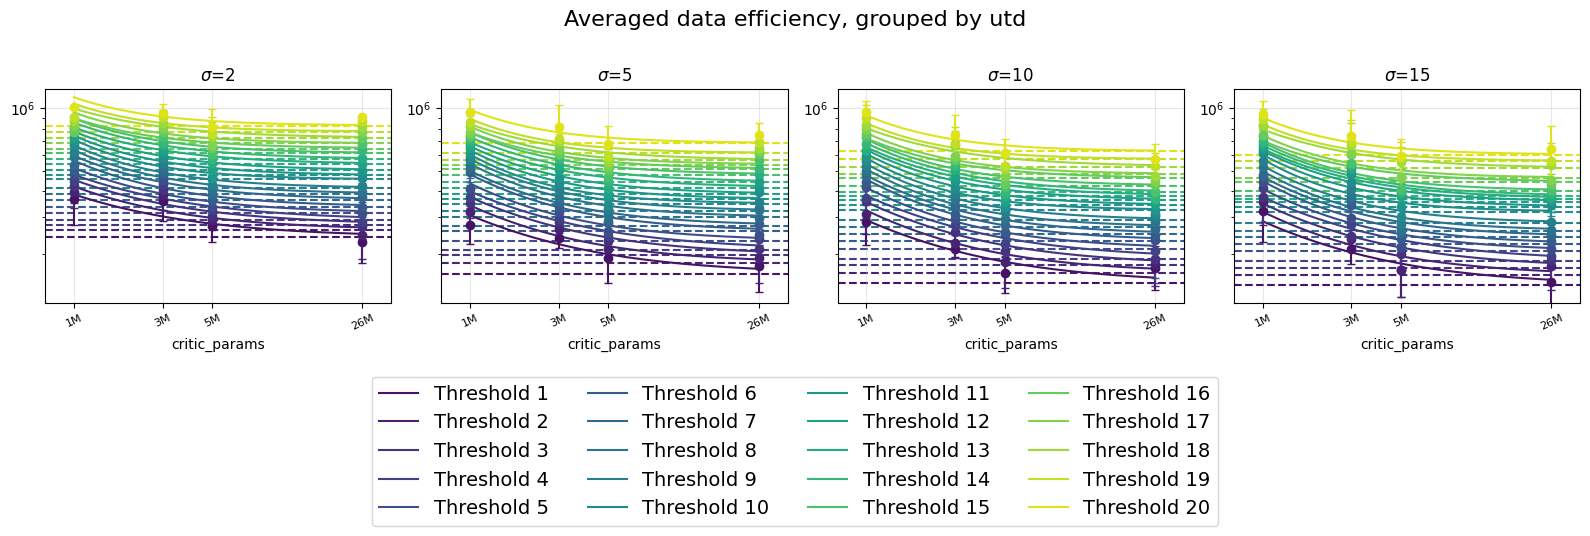

In [33]:
plot_optimal_hparam_fit_per_env_utd_multiple_thresh(
    averaged_threshold_dfs,
    'time',
    'time_std',
    'Averaged data efficiency',
    [
        (
            predict_fns_['sum_powerlaw'],
            {
                'asymptote': asymptotes_per_utd_['sum_powerlaw'],
                # 'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha_{\text{env}}}} + \dfrac{b_{\text{env}}}{N^{\beta_{\text{env}}}}$',
            },
        )
        for predict_fns_, asymptotes_per_utd_ in zip(
            averaged_predict_fns, averaged_asymptotes_per_utd
        )
    ],
)

## Averaged iso plots

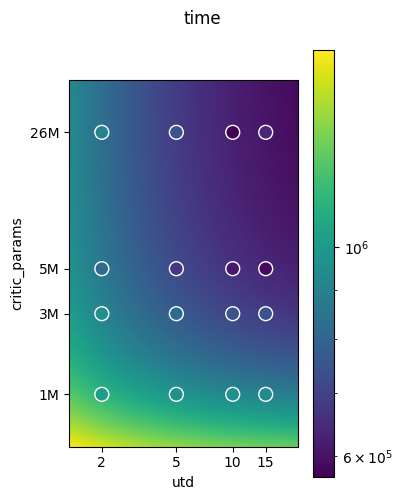

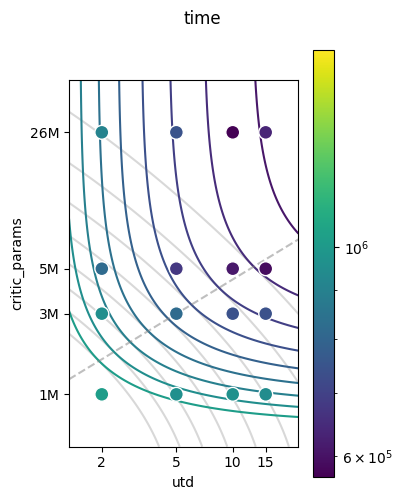

UTD vs N tradeoff for compute conditioned on data
   N = 1.0582e+06 * sigma^0.6101


In [34]:
plot_optimal_hparams_scatter(
    averaged_threshold_dfs[-1],
    averaged_predict_fns[-1]['sum_powerlaw'],
    'time',
    mode='data_predictions',
)

averaged_data_optimal_hparams = plot_optimal_hparams_scatter(
    averaged_threshold_dfs[-1],
    averaged_predict_fns[-1]['sum_powerlaw'],
    'time',
    mode='data_contour',
)

print('UTD vs N tradeoff for compute conditioned on data')
averaged_data_optimal_hparam_relation = compute_optimal_slope_and_intercept(
    averaged_data_optimal_hparams
)
pretty_print_dict(
    {
        row['env_name']: row['eq_sigma_to_n']
        for _, row in averaged_data_optimal_hparam_relation.iterrows()
    }
)

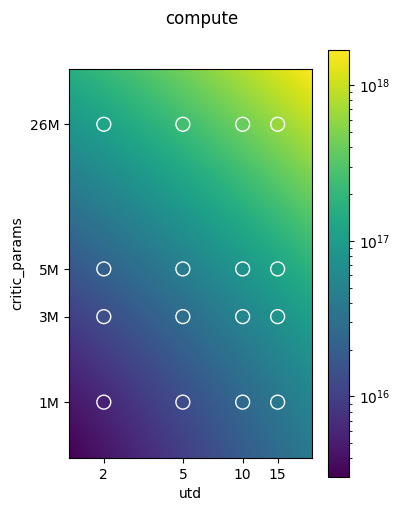

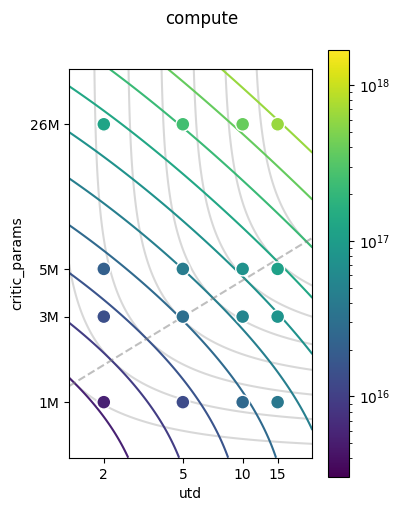

UTD vs N tradeoff for data conditioned on compute
   N = 1.0592e+06 * sigma^0.6094


In [35]:
plot_optimal_hparams_scatter(
    averaged_threshold_dfs[-1],
    averaged_predict_fns[-1]['sum_powerlaw'],
    'time',
    mode='compute_predictions',
)

averaged_compute_optimal_hparams = plot_optimal_hparams_scatter(
    averaged_threshold_dfs[-1],
    averaged_predict_fns[-1]['sum_powerlaw'],
    'time',
    mode='compute_contour',
)

print('UTD vs N tradeoff for data conditioned on compute')
averaged_optimal_hparam_relation = compute_optimal_slope_and_intercept(
    averaged_compute_optimal_hparams
)
pretty_print_dict(
    {
        row['env_name']: row['eq_sigma_to_n']
        for _, row in averaged_optimal_hparam_relation.iterrows()
    }
)

# Budget optimal

In [36]:
delta_dict = defaultdict(lambda: '1e11')

In [ ]:
def compute_multiple_optimal_budget(multiple_crossings_df, infos, delta_dict, use_cached):
    results = []
    for env, group in multiple_crossings_df.groupby('env_name'):
        delta_str = delta_dict[env]

        cache_file = f'budget_optimal/{anonymous_data_config.name}/multiple_budget_optimal_hparams_{env}_{delta_str}_250514.csv'
        if use_cached and os.path.exists(cache_file):
            env_hparams = pd.read_csv(cache_file)
        else:
            env_hparams = compute_optimal_budget(
                group,
                params_per_thresh=[
                    infos[i]['sum_of_powerlaw_shared_exp']['params'] for i in range(n_thresholds)
                ],
                data_efficiency_key_prefix='crossing',
                delta=float(delta_str),
            )
        results.append(env_hparams)
    return pd.concat(results)


multiple_budget_optimal_hparams = compute_multiple_optimal_budget(
    multiple_crossings_df,
    time_to_thresholds_infos_utd,
    delta_dict,
    use_cached=global_use_cached and True,
)

In [38]:
multiple_budget_optimal_hparams_with_fit = insert_budget_fitted_hparams(
    multiple_budget_optimal_hparams.query(
        '(env_name=="humanoid-stand" and threshold_idx>0) or (env_name!="humanoid-stand")'
    ),
    params_per_thresh=[
        time_to_thresholds_infos_utd[i]['sum_powerlaw']['params'] for i in range(n_thresholds)
    ],
)

print(
    'data error:',
    (
        multiple_budget_optimal_hparams_with_fit['budget_fitted_utd_n_data']
        / multiple_budget_optimal_hparams_with_fit['budget_fitted_data_efficiency']
        - 1
    )
    .abs()
    .mean(),
    'compute error:',
    (
        multiple_budget_optimal_hparams_with_fit['budget_fitted_utd_n_compute']
        / multiple_budget_optimal_hparams_with_fit['budget_fitted_compute']
        - 1
    )
    .abs()
    .mean(),
)

multiple_budget_optimal_hparams_with_fit

data error: 0.45918097698744603 compute error: 0.3507988685129631


/home/anonymous/model_scaling_project/single/scripts/core/fitting.py:847: RuntimeWarning: invalid value encountered in divide
  x_scaled = np.exp((np.log(x) - m) / s)
/home/anonymous/model_scaling_project/single/scripts/core/fitting.py:847: RuntimeWarning: invalid value encountered in divide
  x_scaled = np.exp((np.log(x) - m) / s)


env_name         delta  threshold_idx    opt_budget   opt_utd  \
0         dog-run  1.000000e+11              0  3.443761e+16  3.717745   
1         dog-run  1.000000e+11              1  3.631555e+16  3.594566   
2         dog-run  1.000000e+11              2  4.002560e+16  2.399103   
3         dog-run  1.000000e+11              3  4.310544e+16  3.475468   
4         dog-run  1.000000e+11              4  4.712297e+16  3.360317   
..            ...           ...            ...           ...       ...   
15  humanoid-walk  1.000000e+11             15  8.932522e+16  6.883319   
16  humanoid-walk  1.000000e+11             16  8.937113e+16  6.052679   
17  humanoid-walk  1.000000e+11             17  1.047123e+17  6.514215   
18  humanoid-walk  1.000000e+11             18  1.109570e+17  6.395632   
19  humanoid-walk  1.000000e+11             19  1.215060e+17  4.115254   

    opt_critic_params  data_efficiency       compute  budget_fitted_utd  \
0        3.870853e+06    251662.283638  9.271380e+15          16.625377   
1        3.461210e+06    275430.041702  8.772548e+15          10.697560   
2        3.592699e+06    327903.229993  7.235282e+15           3.966792   
3        3.592699e+06    326643.071098  1.044113e+16           0.555556   
4        3.729184e+06    356776.066679  1.144537e+16           0.555556   
..                ...              ...           ...                ...   
15       2.047711e+06    656400.853504  2.368513e+16           6.883319   
16       2.540053e+06    641307.150887  2.524041e+16           6.052679   
17       2.047711e+06    780570.407001  2.665526e+16           6.514215   
18       2.047711e+06    830972.066649  2.785984e+16           6.395632   
19       2.280635e+06    979677.246084  2.353832e+16           4.115254   

    budget_fitted_critic_params  budget_fitted_data_efficiency  \
0                  1.072869e+06                  145598.922172   
1                  1.650801e+06                  206631.586413   
2                  2.540053e+06                  224447.959237   
3                  3.703372e+06                  173402.580876   
4                  4.593792e+06                  180686.610795   
..                          ...                            ...   
15                 2.047711e+06                  663474.123037   
16                 2.540053e+06                  663796.593965   
17                 2.047711e+06                  771074.902499   
18                 2.047711e+06                  814491.606714   
19                 2.280635e+06                  887536.255063   

    budget_fitted_compute  budget_fitted_utd_n_data  \
0            2.541315e+15             279025.025848   
1            4.251139e+15             230539.130045   
2            4.800588e+15             253743.762983   
3            3.285510e+15             839239.075723   
4            3.490329e+15             667008.322927   
..                    ...                       ...   
15           2.360922e+16             559420.208125   
16           2.362609e+16             573722.506467   
17           2.944496e+16             673522.393386   
18           3.191351e+16             696900.185609   
19           3.620701e+16             793941.862611   

    budget_fitted_utd_n_compute  
0                  6.648388e+15  
1                  9.341489e+15  
2                  5.789457e+15  
3                  9.133144e+14  
4                  1.180497e+15  
..                          ...  
15                 2.394036e+16  
16                 2.612555e+16  
17                 2.633100e+16  
18                 2.730730e+16  
19                 2.132448e+16  

[120 rows x 14 columns]

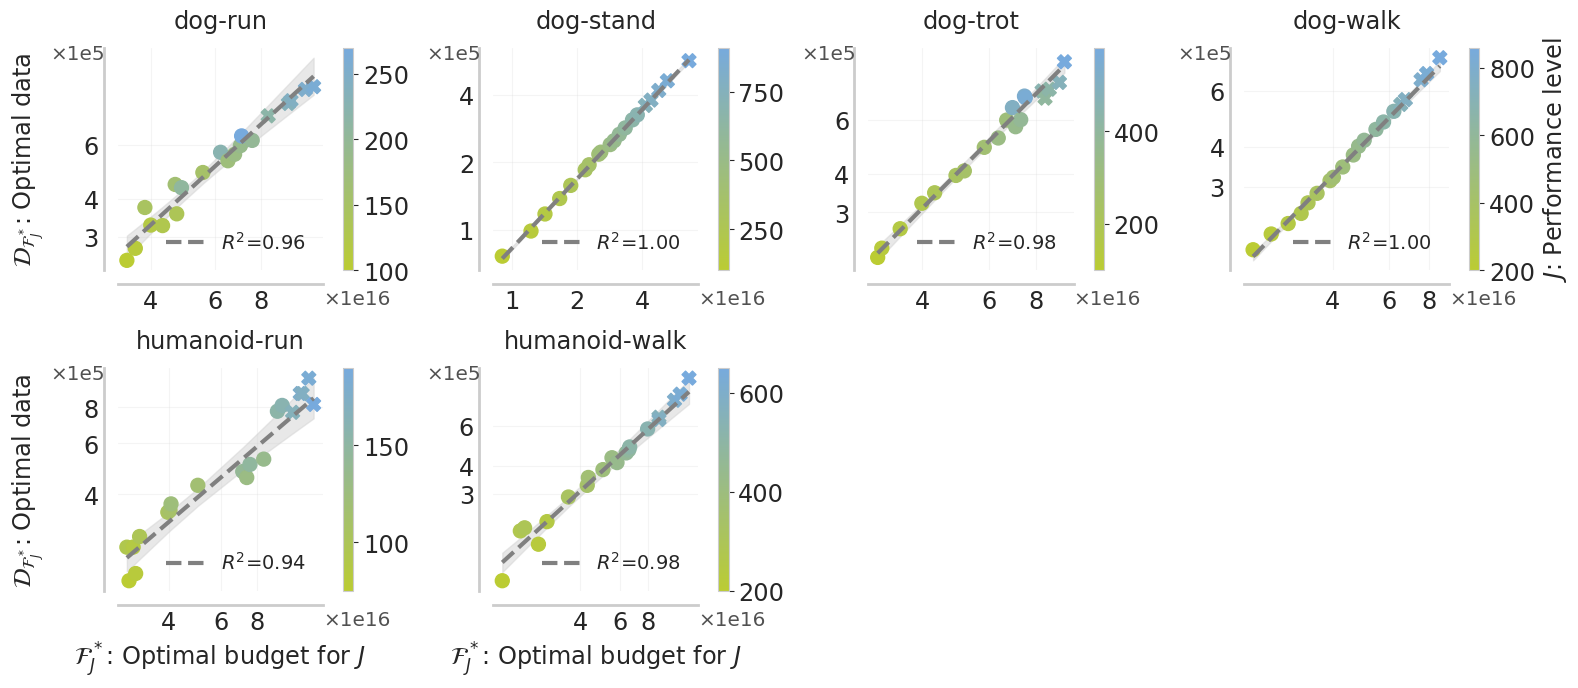

In [39]:
plot_budget_data_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'dog-run': [4e16, 6e16, 8e16],
        'dog-stand': [1e16, 2e16, 4e16],
        'dog-trot': [4e16, 6e16, 8e16],
        'dog-walk': [4e16, 6e16, 8e16],
        'humanoid-run': [4e16, 6e16, 8e16],
        'humanoid-walk': [4e16, 6e16, 8e16],
    },
    xscale='1e16',
    data_yticks={
        'dog-run': [3e5, 4e5, 6e5],
        'dog-stand': [1e5, 2e5, 4e5],
        'dog-trot': [3e5, 4e5, 6e5],
        'dog-walk': [3e5, 4e5, 6e5],
        'humanoid-run': [4e5, 6e5, 8e5],
        'humanoid-walk': [3e5, 4e5, 6e5],
    },
    data_yscale='1e5',
    num_extrapolated_points=5,
    save_path=f'../final_plots/{BENCHMARK_NAME}_budget_data_opt.pdf',
)

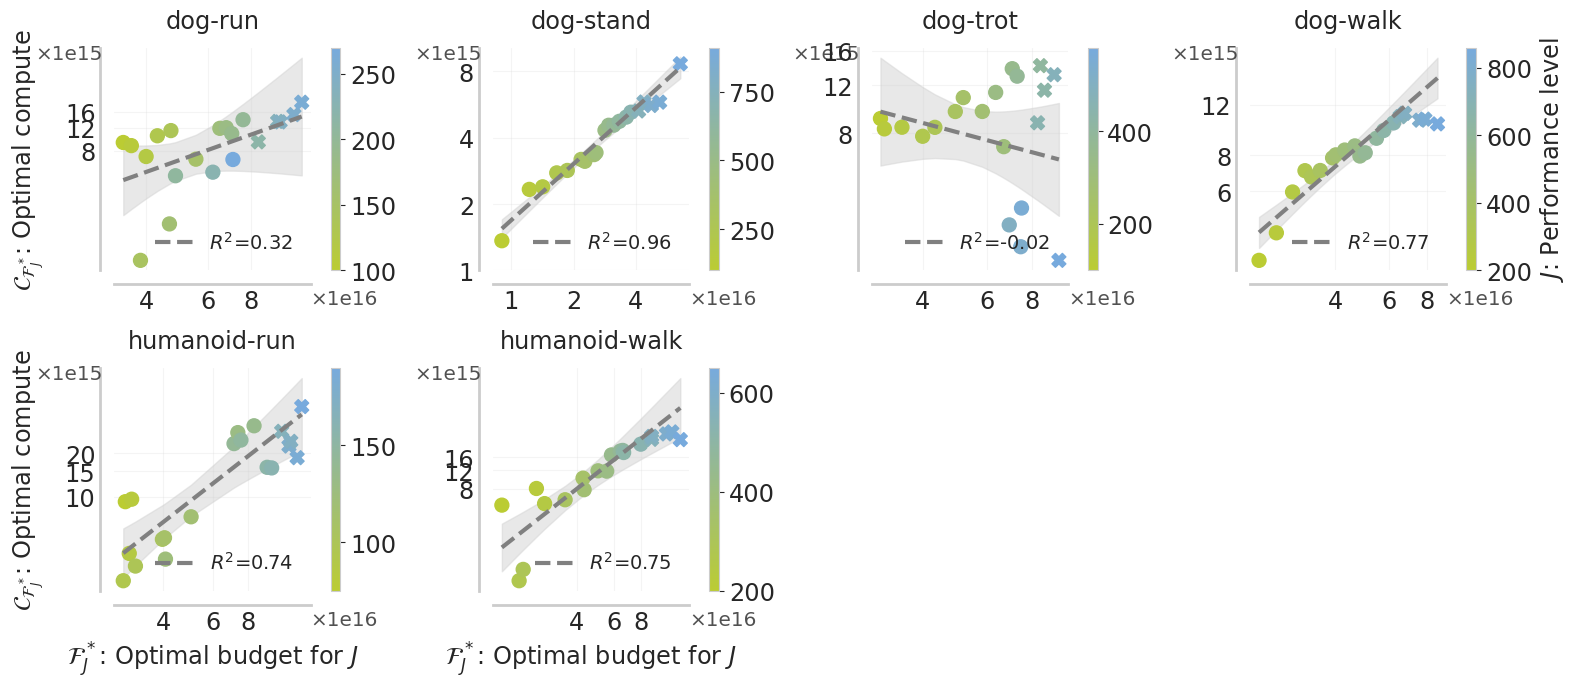

In [40]:
plot_budget_compute_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'dog-run': [4e16, 6e16, 8e16],
        'dog-stand': [1e16, 2e16, 4e16],
        'dog-trot': [4e16, 6e16, 8e16],
        'dog-walk': [4e16, 6e16, 8e16],
        'humanoid-run': [4e16, 6e16, 8e16],
        'humanoid-walk': [4e16, 6e16, 8e16],
    },
    xscale='1e16',
    compute_yticks={
        'dog-run': [8e15, 12e15, 16e15],
        'dog-stand': [1e15, 2e15, 4e15, 8e15],
        'dog-trot': [8e15, 12e15, 16e15],
        'dog-walk': [6e15, 8e15, 12e15],
        'humanoid-run': [10e15, 15e15, 20e15],
        'humanoid-walk': [8e15, 12e15, 16e15],
    },
    compute_yscale='1e15',
    num_extrapolated_points=5,
    save_path=f'../final_plots/{BENCHMARK_NAME}_budget_compute_opt.pdf',
)

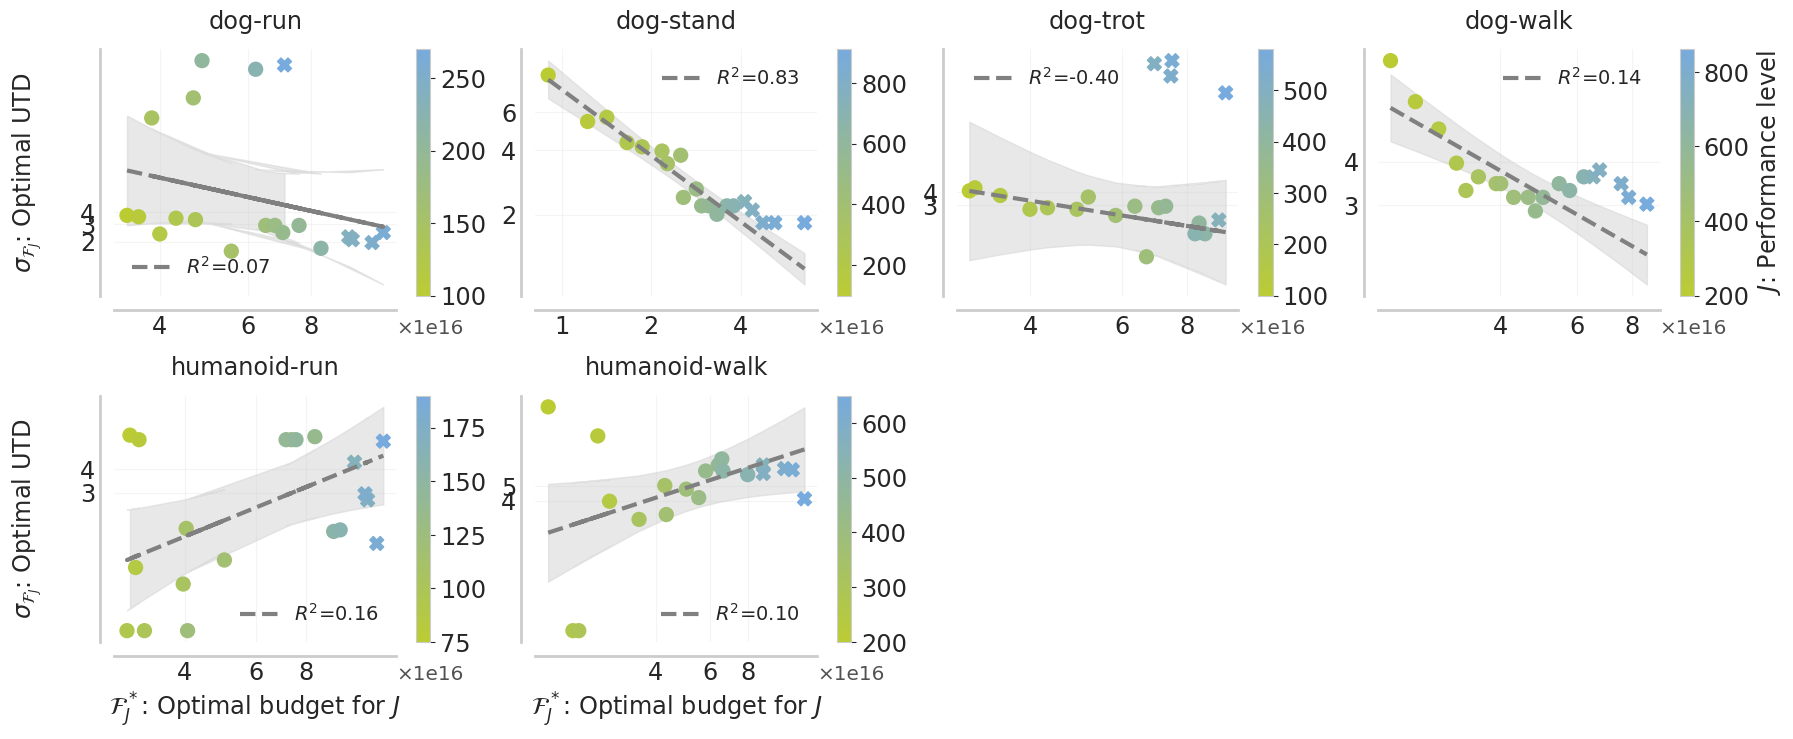

In [41]:
plot_budget_sigma_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'dog-run': [4e16, 6e16, 8e16],
        'dog-stand': [1e16, 2e16, 4e16],
        'dog-trot': [4e16, 6e16, 8e16],
        'dog-walk': [4e16, 6e16, 8e16],
        'humanoid-run': [4e16, 6e16, 8e16],
        'humanoid-walk': [4e16, 6e16, 8e16],
    },
    xscale='1e16',
    sigma_yticks={
        'dog-run': [2, 3, 4],
        'dog-stand': [2, 4, 6],
        'dog-trot': [3, 4],
        'dog-walk': [3, 4],
        'humanoid-run': [3, 4],
        'humanoid-walk': [4, 5],
    },
    sigma_yscale='1',
    num_extrapolated_points=5,
    save_path=f'../final_plots/{BENCHMARK_NAME}_budget_sigma_opt.pdf',
)

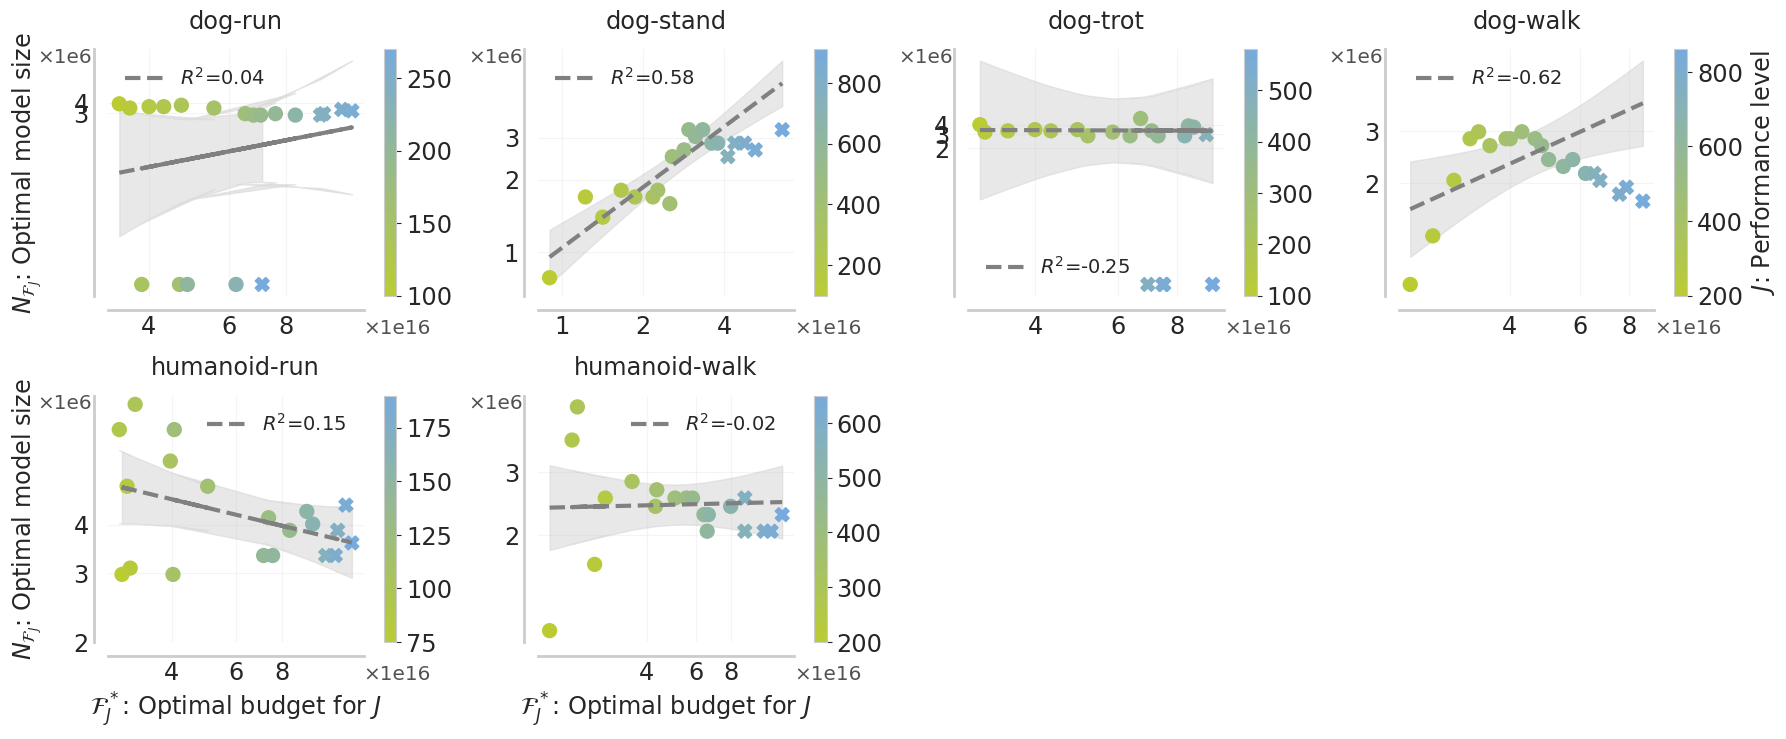

In [42]:
plot_budget_n_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'dog-run': [4e16, 6e16, 8e16],
        'dog-stand': [1e16, 2e16, 4e16],
        'dog-trot': [4e16, 6e16, 8e16],
        'dog-walk': [4e16, 6e16, 8e16],
        'humanoid-run': [4e16, 6e16, 8e16],
        'humanoid-walk': [4e16, 6e16, 8e16],
    },
    xscale='1e16',
    n_yticks={
        'dog-run': [3e6, 4e6],
        'dog-stand': [1e6, 2e6, 3e6],
        'dog-trot': [2e6, 3e6, 4e6],
        'dog-walk': [2e6, 3e6],
        'humanoid-run': [2e6, 3e6, 4e6],
        'humanoid-walk': [2e6, 3e6],
    },
    n_yscale='1e6',
    num_extrapolated_points=5,
    save_path=f'../final_plots/{BENCHMARK_NAME}_budget_n_opt.pdf',
)

## Averaged budget optimal

In [43]:
def make_averaged_multiple_crossings_df(averaged_threshold_dfs):
    df = averaged_threshold_dfs[0][['env_name', 'utd', 'critic_params']]
    for i in range(n_thresholds):
        df[f'crossing{i}'] = averaged_threshold_dfs[i][f'time']
        df[f'crossing{i}_std'] = averaged_threshold_dfs[i][f'time_std']
    return df


averaged_multiple_crossings_df = make_averaged_multiple_crossings_df(averaged_threshold_dfs)

In [ ]:
averaged_config = deepcopy(anonymous_data_config)
averaged_config.name += '_averaged'

In [45]:
averaged_generic_fit_infos = {
    'loglinear_shared': {
        'color': 'tab:orange',
        'label': r'$D \sim a_{\text{env},\sigma} \cdot N^{\beta}$',
    },
    'sum_powerlaw': {
        'color': 'tab:purple',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha_{\text{env}}}} + \dfrac{b_{\text{env}}}{N^{\beta_{\text{env}}}}$',
    },
    'sum_of_powerlaw_shared_exp': {
        'color': 'darkturquoise',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha}} + \dfrac{b_{\text{env}}}{N^{\beta}}$',
    },
}

averaged_time_to_thresholds_predictors = [{} for _ in range(n_thresholds)]
averaged_time_to_thresholds_infos_utd = [
    deepcopy(averaged_generic_fit_infos) for _ in range(n_thresholds)
]
averaged_time_to_thresholds_infos_n = [
    deepcopy(averaged_generic_fit_infos) for _ in range(n_thresholds)
]

averaged_multiple_crossings_state = (
    averaged_multiple_crossings_df,
    averaged_time_to_thresholds_predictors,
    averaged_time_to_thresholds_infos_utd,
    averaged_time_to_thresholds_infos_n,
)

In [46]:
averaged_multiple_crossings_state = insert_multiple_shared_slope(
    averaged_multiple_crossings_state, fn=insert_predictions
)

: log crossing0 ~ 1.5338e+01 + -0.2020 * log utd + -0.1722 * log critic_params
: log crossing1 ~ 1.5436e+01 + -0.1935 * log utd + -0.1737 * log critic_params
: log crossing2 ~ 1.5509e+01 + -0.1807 * log utd + -0.1743 * log critic_params
: log crossing3 ~ 1.5541e+01 + -0.1676 * log utd + -0.1734 * log critic_params
: log crossing4 ~ 1.5577e+01 + -0.1617 * log utd + -0.1718 * log critic_params
: log crossing5 ~ 1.5667e+01 + -0.1588 * log utd + -0.1728 * log critic_params
: log crossing6 ~ 1.5593e+01 + -0.1590 * log utd + -0.1641 * log critic_params
: log crossing7 ~ 1.5622e+01 + -0.1597 * log utd + -0.1617 * log critic_params
: log crossing8 ~ 1.5597e+01 + -0.1530 * log utd + -0.1567 * log critic_params
: log crossing9 ~ 1.5466e+01 + -0.1434 * log utd + -0.1445 * log critic_params
: log crossing10 ~ 1.5497e+01 + -0.1382 * log utd + -0.1434 * log critic_params
: log crossing11 ~ 1.5499e+01 + -0.1374 * log utd + -0.1399 * log critic_params
: log crossing12 ~ 1.5481e+01 + -0.1530 * log utd 

In [47]:
averaged_multiple_crossings_state = insert_multiple_sum_powerlaw(
    averaged_multiple_crossings_state, averaged_config, use_cached=False
)

 20%|██        | 4/20 [00:00<00:00, 35.21it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing0/utd_critic_params_crossing0_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing1/utd_critic_params_crossing1_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing2/utd_critic_params_crossing2_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing3/utd_critic_params_crossing3_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing4/utd_critic_params_crossin

 40%|████      | 8/20 [00:00<00:00, 31.80it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing7/utd_critic_params_crossing7_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing8/utd_critic_params_crossing8_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing9/utd_critic_params_crossing9_sum_powerlaw.npy


 60%|██████    | 12/20 [00:00<00:00, 30.43it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing10/utd_critic_params_crossing10_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing11/utd_critic_params_crossing11_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing12/utd_critic_params_crossing12_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing13/utd_critic_params_crossing13_sum_powerlaw.npy


 80%|████████  | 16/20 [00:00<00:00, 31.00it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing14/utd_critic_params_crossing14_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing15/utd_critic_params_crossing15_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing16/utd_critic_params_crossing16_sum_powerlaw.npy


100%|██████████| 20/20 [00:00<00:00, 31.09it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing17/utd_critic_params_crossing17_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing18/utd_critic_params_crossing18_sum_powerlaw.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing19/utd_critic_params_crossing19_sum_powerlaw.npy


In [48]:
averaged_multiple_crossings_state = insert_multiple_sum_powerlaw_shared_exp(
    averaged_multiple_crossings_state, averaged_config, use_cached=False
)

  0%|          | 0/20 [00:00<?, ?it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing0/utd_critic_params_crossing0_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing1/utd_critic_params_crossing1_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing2/utd_critic_params_crossing2_sum_of_powerlaw_shared_exp_no_log_loss.npy


 20%|██        | 4/20 [00:00<00:00, 30.21it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing3/utd_critic_params_crossing3_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing4/utd_critic_params_crossing4_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing5/utd_critic_params_crossing5_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing6/utd_critic_params_crossing6_sum_of_powerlaw_shared_exp_no_log_loss.npy


 40%|████      | 8/20 [00:00<00:00, 29.05it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing7/utd_critic_params_crossing7_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing8/utd_critic_params_crossing8_sum_of_powerlaw_shared_exp_no_log_loss.npy


 55%|█████▌    | 11/20 [00:00<00:00, 28.09it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing9/utd_critic_params_crossing9_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing10/utd_critic_params_crossing10_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing11/utd_critic_params_crossing11_sum_of_powerlaw_shared_exp_no_log_loss.npy


 70%|███████   | 14/20 [00:00<00:00, 25.59it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing12/utd_critic_params_crossing12_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing13/utd_critic_params_crossing13_sum_of_powerlaw_shared_exp_no_log_loss.npy


 85%|████████▌ | 17/20 [00:00<00:00, 25.97it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing14/utd_critic_params_crossing14_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing15/utd_critic_params_crossing15_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing16/utd_critic_params_crossing16_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing17/utd_critic_params_crossing17_sum_of_powerlaw_shared_exp_no_log_loss.npy


/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[idx, f'{ycol}_sum_of_powerlaw_shared_exp'] = predict_sum_of_powerlaw_shared_exponent(
/home/anonymous/model_scaling_project/single/scripts/core/bootstrapping.py:919: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[idx, f'{ycol}_sum_of_powerlaw_shared_exp'] = predict_sum_of_powerlaw_shared_exponent(
100%|██████████| 20/20 [00:00<00:00, 26.61it/s]

Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing18/utd_critic_params_crossing18_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/anonymous/model_scaling_project/single/scripts/core/../experiments/fits/anonymous_bro_dog_humanoid_linear20_with_base_averaged_crossing19/utd_critic_params_crossing19_sum_of_powerlaw_shared_exp_no_log_loss.npy


In [49]:
(
    averaged_multiple_crossings_df,
    averaged_time_to_thresholds_predictors,
    averaged_time_to_thresholds_infos_utd,
    averaged_time_to_thresholds_infos_n,
) = averaged_multiple_crossings_state

In [50]:
averaged_multiple_budget_optimal_hparams = compute_multiple_optimal_budget(
    averaged_multiple_crossings_df,
    averaged_time_to_thresholds_infos_utd,
    delta_dict={'': '1e11'},
    use_cached=False,
)
averaged_multiple_budget_optimal_hparams['env_name'] = ''

100%|██████████| 20/20 [00:00<00:00, 583.44it/s]


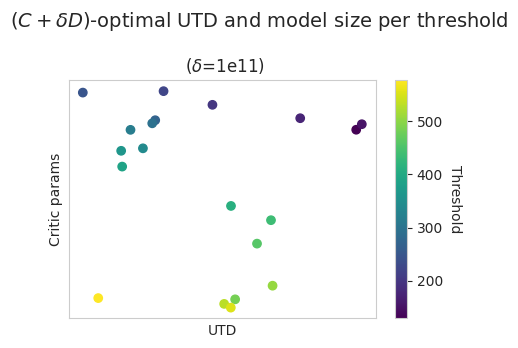

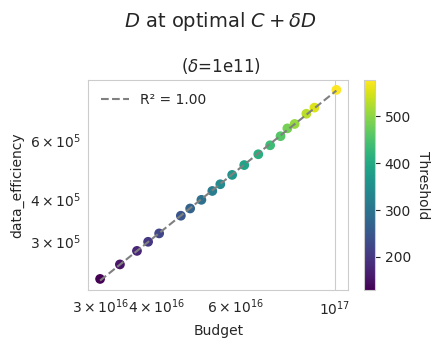

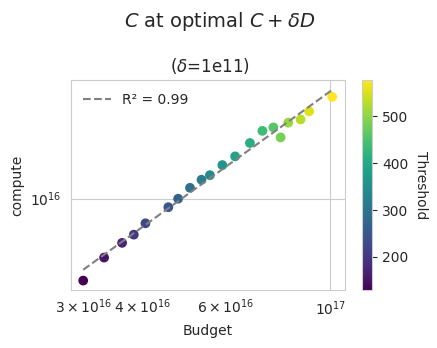

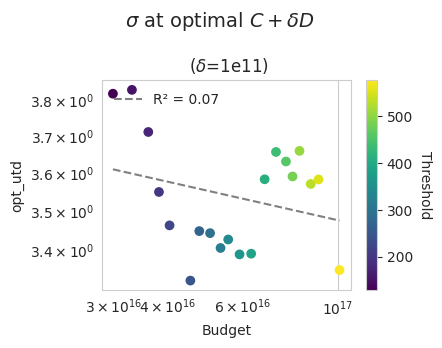

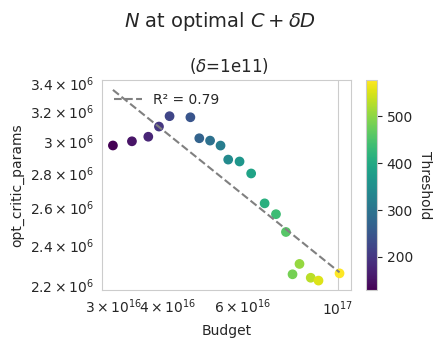

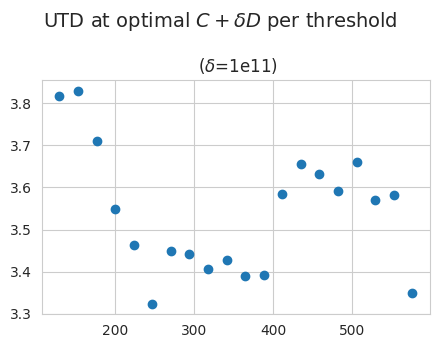

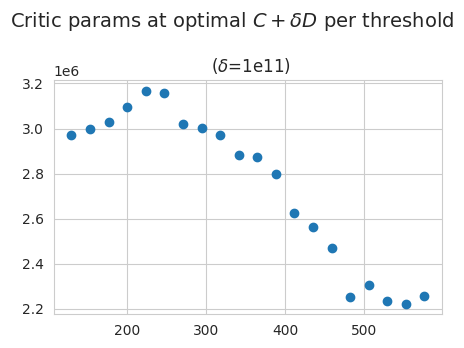

In [51]:
averaged_optimal_d_budget_fit, averaged_optimal_c_budget_fit = compute_budget_data_compute_equation(
    averaged_multiple_budget_optimal_hparams
)
plot_multiple_budget_optimal(
    averaged_multiple_budget_optimal_hparams,
    delta_dict={'': '1e11'},
    thresholds_per_env=pd.Series({'': np.stack(thresholds_per_env.values).mean(axis=0)}),
)